# bibliotecas utilizadas

In [1]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.integrate import simps
from scipy.signal import gaussian

from multiprocessing import Pool

from core.evolution import imaginary
from core.empirical import in_segregation

au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## função que gera o perfil de concentração

In [2]:
def concentration(x0, R, ml):
    # 2 monolayers requires 100 surrounding
    # 20 monolayers requires 10 surrounding
    # but let's force at least 10
    nsl = max(10,int(110+(10-100/(20-2))*ml)) # number of surrounding layers (each side)
    
    tl = ml + 2 * nsl  # total layers
    # bulk before well
    x = [0] * nsl
    # well
    for n in range(1, ml+1):
        x.append(in_segregation(x0, R, n))
    # barrier after well
    for n in range(1, nsl+1):
        x.append(in_segregation(x0, R, n+ml, ml))
    return np.arange(1, len(x)+1), np.array(x)

## parâmetros buscados

In [3]:
x0      = 0.14
tT      = [525, 475]
tR      = [0.867, 0.778]
N       = 1024
offset  = (0.7, 0.3)
ml_grid = [10, 15, 21, 28]

## parâmetros de acordo com Martini

In [4]:
a0   = np.vectorize(lambda x:  6.0584 * x + (1-x) *  5.6533 )
a    = np.vectorize(lambda x: -6.08   * x + (1-x) * -8.33   )
b    = np.vectorize(lambda x: -1.8    * x + (1-x) * -1.7    )
c11  = np.vectorize(lambda x:  0.8329 * x + (1-x) *  1.1879 )
c12  = np.vectorize(lambda x:  0.4526 * x + (1-x) *  0.5376 )
me   = np.vectorize(lambda x: 0.023   * x + (1-x) *  0.067  )
mhhz = np.vectorize(lambda x: 0.263   * x + (1-x) *  0.333  )

## cálculo de acordo com o número de monolayers

In [5]:
PL_numeric   = {}
PLR_envelope = {}
PLR_e_hh     = {}
PLR_hh       = {}
infos_e      = []
infos_h      = []

# R = tR[0]
# T = tT[0]

for ax in np.linspace(-0.5,0.5,10):
    for bx in np.linspace(-0.5,0.5,10):
        for cx in np.linspace(-0.5,0.5,10):
            print(ax)
            print(bx)
            print(cx)
            # for gapx in np.linspace(0,1,10):
            for R, T in zip(tR, tT):
                PL_numeric[T]   = []
                PLR_envelope[T] = []
                PLR_e_hh[T]     = []
                PLR_hh[T]       = []

                for ml in ml_grid:
                    layers, in_x = concentration(x0, R, ml)

                    def concentration_z(z):
                        position = 0.0
                        for x, a in zip(in_x, a0(in_x)):
                            position += a/2.0
                            if z < position:
                                return x
                        return in_x[0]

                    z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
                    in_x_z = np.vectorize(concentration_z)(z)

                    #gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)
                    gap_2   = np.vectorize(lambda x: 0.422+0.7*(1-x)+0.4*(1-x)**2)(in_x_z)
                    gap_300 = np.vectorize(lambda x: 0.324+0.7*(1-x)+0.4*(1-x)**2)(in_x_z)
                    gap = gap_2 + (77-2)*(gap_300-gap_2)/(300-2)

                    #gap = gap_2*gapx + gap_300*(1-gapx)
                
                    #gap = np.vectorize(lambda x: 1.519-(6*(1-x)**2-8.6*(1-x)+5.2)*(0.0001*T**2)/(T+(377*(1-x)**2-455*(1-x)+196)))(in_x_z)

#                     _a   = a(in_x_z)
#                     _b   = b(in_x_z)
#                     _c11 = c11(in_x_z)
#                     _c12 = c12(in_x_z)
#                     _epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)
                    gambis = np.vectorize(lambda x: ax*x**2+bx*x+cx)(in_x_z)
                    gap_strain = gap + gambis#(2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11

                    gap_c      = offset[0] * gap_strain
                    gap_v      = offset[1] * gap_strain

                    z_au    = z/au2ang # angstrom to au
                    v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
                    v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au

                    electron   = imaginary(z_au,v_e_au ,  np.max(me(in_x_z)))
                    infos_e.append(electron)
                    heavy_hole = imaginary(z_au,v_hh_au, np.max(mhhz(in_x_z)))
                    infos_h.append(heavy_hole)

                    Ee      = electron['eigenvalues'][0]* au2ev
                    Ce      = electron['counters'][0]
                    Pe      = electron['precisions'][0]
                    Te      = electron['timers'][0]
                    Se      = electron['squared_euclidean_dist'][0]
                    Ee_es   = electron['eigenstates'][0]

                    Ehh     = heavy_hole['eigenvalues'][0]* au2ev
                    Chh     = heavy_hole['counters'][0]
                    Phh     = heavy_hole['precisions'][0]
                    Thh     = heavy_hole['timers'][0]
                    Shh     = heavy_hole['squared_euclidean_dist'][0]
                    Ehh_es  = heavy_hole['eigenstates'][0]

                    ###############################################################
                    envelope  = Ee_es + Ehh_es
                    envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
                    z_med     = simps(envelope.conj()*z*envelope,z)
                    idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
                    gap_min = gap_strain[idx]
                    plr_envelope = gap_min+Ehh+Ee-7e-3
                    PLR_envelope[T].append(plr_envelope)

                    ###############################################################
                    Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
                    Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
                    z_med  = simps(Ehh_es.conj()*z*Ee_es,z)
                    idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
                    gap_min = gap_strain[idx]
                    plr_e_hh = gap_min+Ehh+Ee-7e-3
                    PLR_e_hh[T].append(plr_e_hh)

                    ###############################################################
                    Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
                    z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)
                    idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
                    gap_min = gap_strain[idx]
                    plr_hh = gap_min+Ehh+Ee-7e-3
                    PLR_hh[T].append(plr_hh)

                    ###############################################################
                    gap_min = np.min(gap_strain)
                    pl = gap_min+Ehh+Ee-7e-3
                    PL_numeric[T].append(pl)

                    #print("GAP x: %.2f" % gapx)
                    print("ML={0:02d}, T={1} C, R={2:.3f}, PL={3:.8f} eV, PL_env={4:.8f} eV, PL_e_hh={5:.8f} eV, PL_hh={6:.8f} eV, ".format(
                        ml, T, R, pl, plr_envelope, plr_e_hh, plr_hh))

-0.5
-0.5
-0.5
ML=10, T=525 C, R=0.867, PL=0.90912018 eV, PL_env=0.90912018 eV, PL_e_hh=0.97971365 eV, PL_hh=0.90912018 eV, 
ML=15, T=525 C, R=0.867, PL=0.86273845 eV, PL_env=0.88054036 eV, PL_e_hh=0.90782577 eV, PL_hh=0.88054036 eV, 
ML=21, T=525 C, R=0.867, PL=0.82093264 eV, PL_env=0.83567995 eV, PL_e_hh=0.85111843 eV, PL_hh=0.83567995 eV, 
ML=28, T=525 C, R=0.867, PL=0.78756905 eV, PL_env=0.79869475 eV, PL_e_hh=0.80742483 eV, PL_hh=0.79869475 eV, 
ML=10, T=475 C, R=0.778, PL=0.89209512 eV, PL_env=0.90711515 eV, PL_e_hh=0.97279733 eV, PL_hh=0.90711515 eV, 
ML=15, T=475 C, R=0.778, PL=0.84189053 eV, PL_env=0.85325500 eV, PL_e_hh=0.88424221 eV, PL_hh=0.85325500 eV, 
ML=21, T=475 C, R=0.778, PL=0.80116841 eV, PL_env=0.80815973 eV, PL_e_hh=0.81764876 eV, PL_hh=0.80815973 eV, 
ML=28, T=475 C, R=0.778, PL=0.77188133 eV, PL_env=0.77472575 eV, PL_e_hh=0.77820365 eV, PL_hh=0.77472575 eV, 
-0.5
-0.5
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.02023129 eV, PL_env=1.02023129 eV, PL_e_hh=1.

ML=15, T=525 C, R=0.867, PL=1.86273845 eV, PL_env=1.88054036 eV, PL_e_hh=1.90782577 eV, PL_hh=1.88054036 eV, 
ML=21, T=525 C, R=0.867, PL=1.82093264 eV, PL_env=1.83567995 eV, PL_e_hh=1.85111843 eV, PL_hh=1.83567995 eV, 
ML=28, T=525 C, R=0.867, PL=1.78756905 eV, PL_env=1.79869475 eV, PL_e_hh=1.80742483 eV, PL_hh=1.79869475 eV, 
ML=10, T=475 C, R=0.778, PL=1.89209512 eV, PL_env=1.90711515 eV, PL_e_hh=1.97279733 eV, PL_hh=1.90711515 eV, 
ML=15, T=475 C, R=0.778, PL=1.84189053 eV, PL_env=1.85325500 eV, PL_e_hh=1.88424221 eV, PL_hh=1.85325500 eV, 
ML=21, T=475 C, R=0.778, PL=1.80116841 eV, PL_env=1.80815973 eV, PL_e_hh=1.81764876 eV, PL_hh=1.80815973 eV, 
ML=28, T=475 C, R=0.778, PL=1.77188133 eV, PL_env=1.77472575 eV, PL_e_hh=1.77820365 eV, PL_hh=1.77472575 eV, 
-0.5
-0.3888888888888889
-0.5
ML=10, T=525 C, R=0.867, PL=0.91541709 eV, PL_env=0.91541709 eV, PL_e_hh=0.98212326 eV, PL_hh=0.91541709 eV, 
ML=15, T=525 C, R=0.867, PL=0.87194450 eV, PL_env=0.88876906 eV, PL_e_hh=0.91455481 eV, PL

ML=10, T=525 C, R=0.867, PL=1.80430598 eV, PL_env=1.80430598 eV, PL_e_hh=1.87101215 eV, PL_hh=1.80430598 eV, 
ML=15, T=525 C, R=0.867, PL=1.76083339 eV, PL_env=1.77765795 eV, PL_e_hh=1.80344370 eV, PL_hh=1.77765795 eV, 
ML=21, T=525 C, R=0.867, PL=1.72130179 eV, PL_env=1.73524027 eV, PL_e_hh=1.74983139 eV, PL_hh=1.73524027 eV, 
ML=28, T=525 C, R=0.867, PL=1.68951492 eV, PL_env=1.70003074 eV, PL_e_hh=1.70828204 eV, PL_hh=1.70003074 eV, 
ML=10, T=475 C, R=0.778, PL=1.78879217 eV, PL_env=1.80298805 eV, PL_e_hh=1.86505913 eV, PL_hh=1.80298805 eV, 
ML=15, T=475 C, R=0.778, PL=1.74160466 eV, PL_env=1.75234611 eV, PL_e_hh=1.78163281 eV, PL_hh=1.75234611 eV, 
ML=21, T=475 C, R=0.778, PL=1.70288880 eV, PL_env=1.70949698 eV, PL_e_hh=1.71846578 eV, PL_hh=1.70949698 eV, 
ML=28, T=475 C, R=0.778, PL=1.67478765 eV, PL_env=1.67747622 eV, PL_e_hh=1.68076352 eV, PL_hh=1.67747622 eV, 
-0.5
-0.3888888888888889
0.5
ML=10, T=525 C, R=0.867, PL=1.91541709 eV, PL_env=1.91541709 eV, PL_e_hh=1.98212326 eV, PL_

ML=10, T=525 C, R=0.867, PL=1.69937857 eV, PL_env=1.69937857 eV, PL_e_hh=1.76219744 eV, PL_hh=1.69937857 eV, 
ML=15, T=525 C, R=0.867, PL=1.65881492 eV, PL_env=1.67466212 eV, PL_e_hh=1.69894822 eV, PL_hh=1.67466212 eV, 
ML=21, T=525 C, R=0.867, PL=1.62157863 eV, PL_env=1.63470828 eV, PL_e_hh=1.64845203 eV, PL_hh=1.63470828 eV, 
ML=28, T=525 C, R=0.867, PL=1.59139231 eV, PL_env=1.60129825 eV, PL_e_hh=1.60907075 eV, PL_hh=1.60129825 eV, 
ML=10, T=475 C, R=0.778, PL=1.68533609 eV, PL_env=1.69870782 eV, PL_e_hh=1.75716779 eV, PL_hh=1.69870782 eV, 
ML=15, T=475 C, R=0.778, PL=1.64118258 eV, PL_env=1.65130102 eV, PL_e_hh=1.67888721 eV, PL_hh=1.65130102 eV, 
ML=21, T=475 C, R=0.778, PL=1.60451060 eV, PL_env=1.61073565 eV, PL_e_hh=1.61918423 eV, PL_hh=1.61073565 eV, 
ML=28, T=475 C, R=0.778, PL=1.57762816 eV, PL_env=1.58016086 eV, PL_e_hh=1.58325757 eV, PL_hh=1.58016086 eV, 
-0.5
-0.2777777777777778
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.81048968 eV, PL_env=1.81048968 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.59432893 eV, PL_env=1.59432893 eV, PL_e_hh=1.65326051 eV, PL_hh=1.59432893 eV, 
ML=15, T=525 C, R=0.867, PL=1.55667400 eV, PL_env=1.57154385 eV, PL_e_hh=1.59433028 eV, PL_hh=1.57154385 eV, 
ML=21, T=525 C, R=0.867, PL=1.52175355 eV, PL_env=1.53407437 eV, PL_e_hh=1.54697076 eV, PL_hh=1.53407437 eV, 
ML=28, T=525 C, R=0.867, PL=1.49319366 eV, PL_env=1.50248972 eV, PL_e_hh=1.50978343 eV, PL_hh=1.50248972 eV, 
ML=10, T=475 C, R=0.778, PL=1.58171478 eV, PL_env=1.59426236 eV, PL_e_hh=1.67374265 eV, PL_hh=1.59426236 eV, 
ML=15, T=475 C, R=0.778, PL=1.54061310 eV, PL_env=1.55010853 eV, PL_e_hh=1.57599420 eV, PL_hh=1.55010853 eV, 
ML=21, T=475 C, R=0.778, PL=1.50602313 eV, PL_env=1.51186505 eV, PL_e_hh=1.51979340 eV, PL_hh=1.51186505 eV, 
ML=28, T=475 C, R=0.778, PL=1.48039594 eV, PL_env=1.48277279 eV, PL_e_hh=1.48567891 eV, PL_hh=1.48277279 eV, 
-0.5
-0.16666666666666669
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.70544004 eV, PL_env=1.70544004 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.48914888 eV, PL_env=1.48914888 eV, PL_e_hh=1.54419316 eV, PL_hh=1.48914888 eV, 
ML=15, T=525 C, R=0.867, PL=1.45439922 eV, PL_env=1.46829172 eV, PL_e_hh=1.48957849 eV, PL_hh=1.46829172 eV, 
ML=21, T=525 C, R=0.867, PL=1.42181570 eV, PL_env=1.43332769 eV, PL_e_hh=1.44537672 eV, PL_hh=1.43332769 eV, 
ML=28, T=525 C, R=0.867, PL=1.39491166 eV, PL_env=1.40359784 eV, PL_e_hh=1.41041276 eV, PL_hh=1.40359784 eV, 
ML=10, T=475 C, R=0.778, PL=1.47791771 eV, PL_env=1.48964115 eV, PL_e_hh=1.56388411 eV, PL_hh=1.48964115 eV, 
ML=15, T=475 C, R=0.778, PL=1.43988115 eV, PL_env=1.44875356 eV, PL_e_hh=1.47293873 eV, PL_hh=1.44875356 eV, 
ML=21, T=475 C, R=0.778, PL=1.40741504 eV, PL_env=1.41287382 eV, PL_e_hh=1.42028195 eV, PL_hh=1.41287382 eV, 
ML=28, T=475 C, R=0.778, PL=1.38308160 eV, PL_env=1.38530260 eV, PL_e_hh=1.38801812 eV, PL_hh=1.38530260 eV, 
-0.5
-0.05555555555555558
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.60025999 eV, PL_env=1.60025999 eV, PL_e_hh=1

ML=10, T=525 C, R=0.867, PL=1.38382684 eV, PL_env=1.38382684 eV, PL_e_hh=1.43498382 eV, PL_hh=1.38382684 eV, 
ML=15, T=525 C, R=0.867, PL=1.35197771 eV, PL_env=1.36489287 eV, PL_e_hh=1.38467998 eV, PL_hh=1.36489287 eV, 
ML=21, T=525 C, R=0.867, PL=1.32175383 eV, PL_env=1.33245699 eV, PL_e_hh=1.34365865 eV, PL_hh=1.33245699 eV, 
ML=28, T=525 C, R=0.867, PL=1.29653615 eV, PL_env=1.30461245 eV, PL_e_hh=1.31094858 eV, PL_hh=1.30461245 eV, 
ML=10, T=475 C, R=0.778, PL=1.37392772 eV, PL_env=1.38482700 eV, PL_e_hh=1.45383264 eV, PL_hh=1.38482700 eV, 
ML=15, T=475 C, R=0.778, PL=1.33897106 eV, PL_env=1.34722046 eV, PL_e_hh=1.36970512 eV, PL_hh=1.34722046 eV, 
ML=21, T=475 C, R=0.778, PL=1.30867147 eV, PL_env=1.31374712 eV, PL_e_hh=1.32063502 eV, PL_hh=1.31374712 eV, 
ML=28, T=475 C, R=0.778, PL=1.28567476 eV, PL_env=1.28773991 eV, PL_e_hh=1.29026484 eV, PL_hh=1.28773991 eV, 
-0.5
0.05555555555555558
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.49493795 eV, PL_env=1.49493795 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.27835145 eV, PL_env=1.27835145 eV, PL_e_hh=1.32562113 eV, PL_hh=1.27835145 eV, 
ML=15, T=525 C, R=0.867, PL=1.24939408 eV, PL_env=1.26133188 eV, PL_e_hh=1.28766249 eV, PL_hh=1.26133188 eV, 
ML=21, T=525 C, R=0.867, PL=1.22155313 eV, PL_env=1.23144745 eV, PL_e_hh=1.24635862 eV, PL_hh=1.23144745 eV, 
ML=28, T=525 C, R=0.867, PL=1.19805485 eV, PL_env=1.20552127 eV, PL_e_hh=1.21137861 eV, PL_hh=1.20552127 eV, 
ML=10, T=475 C, R=0.778, PL=1.26973056 eV, PL_env=1.27980569 eV, PL_e_hh=1.34357401 eV, PL_hh=1.27980569 eV, 
ML=15, T=475 C, R=0.778, PL=1.23786297 eV, PL_env=1.24548935 eV, PL_e_hh=1.27561805 eV, PL_hh=1.24548935 eV, 
ML=21, T=475 C, R=0.778, PL=1.20977642 eV, PL_env=1.21446892 eV, PL_e_hh=1.22426899 eV, PL_hh=1.21446892 eV, 
ML=28, T=475 C, R=0.778, PL=1.18816342 eV, PL_env=1.19007271 eV, PL_e_hh=1.19240704 eV, PL_hh=1.19007271 eV, 
-0.5
0.16666666666666663
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.38946256 eV, PL_env=1.38946256 eV, PL_e_hh=1

ML=10, T=525 C, R=0.867, PL=1.17270809 eV, PL_env=1.17270809 eV, PL_e_hh=1.21609047 eV, PL_hh=1.17270809 eV, 
ML=15, T=525 C, R=0.867, PL=1.14663094 eV, PL_env=1.15340775 eV, PL_e_hh=1.18176182 eV, PL_hh=1.15759140 eV, 
ML=21, T=525 C, R=0.867, PL=1.12119629 eV, PL_env=1.13028178 eV, PL_e_hh=1.14397237 eV, PL_hh=1.13028178 eV, 
ML=28, T=525 C, R=0.867, PL=1.09945399 eV, PL_env=1.10631053 eV, PL_e_hh=1.11168908 eV, PL_hh=1.10631053 eV, 
ML=10, T=475 C, R=0.778, PL=1.16530692 eV, PL_env=1.17455790 eV, PL_e_hh=1.23308890 eV, PL_hh=1.17455790 eV, 
ML=15, T=475 C, R=0.778, PL=1.13653523 eV, PL_env=1.14353860 eV, PL_e_hh=1.17120099 eV, PL_hh=1.14353860 eV, 
ML=21, T=475 C, R=0.778, PL=1.11070971 eV, PL_env=1.11501908 eV, PL_e_hh=1.12401835 eV, PL_hh=1.11501908 eV, 
ML=28, T=475 C, R=0.778, PL=1.09053164 eV, PL_env=1.09228508 eV, PL_e_hh=1.09442882 eV, PL_hh=1.09228508 eV, 
-0.5
0.2777777777777777
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.28381920 eV, PL_env=1.28381920 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.06687972 eV, PL_env=1.06687972 eV, PL_e_hh=1.10637481 eV, PL_hh=1.06687972 eV, 
ML=15, T=525 C, R=0.867, PL=1.04366605 eV, PL_env=1.04983873 eV, PL_e_hh=1.07565939 eV, PL_hh=1.05364915 eV, 
ML=21, T=525 C, R=0.867, PL=1.02066180 eV, PL_env=1.02893846 eV, PL_e_hh=1.04140847 eV, PL_hh=1.02893846 eV, 
ML=28, T=525 C, R=0.867, PL=1.00071543 eV, PL_env=1.00696209 eV, PL_e_hh=1.01401877 eV, PL_hh=1.00696209 eV, 
ML=10, T=475 C, R=0.778, PL=1.06063404 eV, PL_env=1.06906086 eV, PL_e_hh=1.12235454 eV, PL_hh=1.06906086 eV, 
ML=15, T=475 C, R=0.778, PL=1.03496008 eV, PL_env=1.04134044 eV, PL_e_hh=1.06653651 eV, PL_hh=1.04134044 eV, 
ML=21, T=475 C, R=0.778, PL=1.01144619 eV, PL_env=1.01537242 eV, PL_e_hh=1.02357091 eV, PL_hh=1.01537242 eV, 
ML=28, T=475 C, R=0.778, PL=0.99276054 eV, PL_env=0.99435812 eV, PL_e_hh=0.99736439 eV, PL_hh=0.99435812 eV, 
-0.5
0.38888888888888884
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.17799083 eV, PL_env=1.17799083 eV, PL_e_hh=1.

-0.5
ML=10, T=525 C, R=0.867, PL=0.96084811 eV, PL_env=0.96084811 eV, PL_e_hh=0.99645589 eV, PL_hh=0.96084811 eV, 
ML=15, T=525 C, R=0.867, PL=0.94047493 eV, PL_env=0.94604348 eV, PL_e_hh=0.96933073 eV, PL_hh=0.94948068 eV, 
ML=21, T=525 C, R=0.867, PL=0.91992368 eV, PL_env=0.92739151 eV, PL_e_hh=0.93864093 eV, PL_hh=0.92739151 eV, 
ML=28, T=525 C, R=0.867, PL=0.90181732 eV, PL_env=0.90745409 eV, PL_e_hh=0.91382110 eV, PL_hh=0.90745409 eV, 
ML=10, T=475 C, R=0.778, PL=0.95568661 eV, PL_env=0.96328929 eV, PL_e_hh=1.03040118 eV, PL_hh=0.96328929 eV, 
ML=15, T=475 C, R=0.778, PL=0.93310597 eV, PL_env=0.93886332 eV, PL_e_hh=0.96159308 eV, PL_hh=0.93886332 eV, 
ML=21, T=475 C, R=0.778, PL=0.91195565 eV, PL_env=0.91549875 eV, PL_e_hh=0.92289645 eV, PL_hh=0.91549875 eV, 
ML=28, T=475 C, R=0.778, PL=0.89482600 eV, PL_env=0.89626773 eV, PL_e_hh=0.89898062 eV, PL_hh=0.89626773 eV, 
-0.5
0.5
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.07195922 eV, PL_env=1.07195922 eV, PL_e_hh=1.10756701 eV

ML=15, T=525 C, R=0.867, PL=1.94047493 eV, PL_env=1.94604348 eV, PL_e_hh=1.96933073 eV, PL_hh=1.94948068 eV, 
ML=21, T=525 C, R=0.867, PL=1.91992368 eV, PL_env=1.92739151 eV, PL_e_hh=1.93864093 eV, PL_hh=1.92739151 eV, 
ML=28, T=525 C, R=0.867, PL=1.90181732 eV, PL_env=1.90745409 eV, PL_e_hh=1.91382110 eV, PL_hh=1.90745409 eV, 
ML=10, T=475 C, R=0.778, PL=1.95568661 eV, PL_env=1.96328929 eV, PL_e_hh=2.03040118 eV, PL_hh=1.96328929 eV, 
ML=15, T=475 C, R=0.778, PL=1.93310597 eV, PL_env=1.93886332 eV, PL_e_hh=1.96159308 eV, PL_hh=1.93886332 eV, 
ML=21, T=475 C, R=0.778, PL=1.91195565 eV, PL_env=1.91549875 eV, PL_e_hh=1.92289645 eV, PL_hh=1.91549875 eV, 
ML=28, T=475 C, R=0.778, PL=1.89482600 eV, PL_env=1.89626773 eV, PL_e_hh=1.89898062 eV, PL_hh=1.89626773 eV, 
-0.3888888888888889
-0.5
-0.5
ML=10, T=525 C, R=0.867, PL=0.90961252 eV, PL_env=0.90961252 eV, PL_e_hh=0.97951476 eV, PL_hh=0.90961252 eV, 
ML=15, T=525 C, R=0.867, PL=0.86365029 eV, PL_env=0.88121930 eV, PL_e_hh=0.90818080 eV, PL

ML=10, T=525 C, R=0.867, PL=1.79850141 eV, PL_env=1.79850141 eV, PL_e_hh=1.86840365 eV, PL_hh=1.79850141 eV, 
ML=15, T=525 C, R=0.867, PL=1.75253917 eV, PL_env=1.77010819 eV, PL_e_hh=1.79706969 eV, PL_hh=1.77010819 eV, 
ML=21, T=525 C, R=0.867, PL=1.71113027 eV, PL_env=1.72566831 eV, PL_e_hh=1.74090017 eV, PL_hh=1.72566831 eV, 
ML=28, T=525 C, R=0.867, PL=1.67807860 eV, PL_env=1.68904002 eV, PL_e_hh=1.69764583 eV, PL_hh=1.68904002 eV, 
ML=10, T=475 C, R=0.778, PL=1.78177103 eV, PL_env=1.79658517 eV, PL_e_hh=1.86150931 eV, PL_hh=1.79658517 eV, 
ML=15, T=475 C, R=0.778, PL=1.73205239 eV, PL_env=1.74324995 eV, PL_e_hh=1.77381713 eV, PL_hh=1.74324995 eV, 
ML=21, T=475 C, R=0.778, PL=1.69169094 eV, PL_env=1.69857686 eV, PL_e_hh=1.70792700 eV, PL_hh=1.69857686 eV, 
ML=28, T=475 C, R=0.778, PL=1.66263309 eV, PL_env=1.66543412 eV, PL_e_hh=1.66885956 eV, PL_hh=1.66543412 eV, 
-0.3888888888888889
-0.5
0.5
ML=10, T=525 C, R=0.867, PL=1.90961252 eV, PL_env=1.90961252 eV, PL_e_hh=1.97951476 eV, PL_

ML=28, T=475 C, R=0.778, PL=1.45441759 eV, PL_env=1.45706277 eV, PL_e_hh=1.46029762 eV, PL_hh=1.45706277 eV, 
-0.3888888888888889
-0.3888888888888889
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.69367660 eV, PL_env=1.69367660 eV, PL_e_hh=1.75969154 eV, PL_hh=1.69367660 eV, 
ML=15, T=525 C, R=0.867, PL=1.65062051 eV, PL_env=1.66721218 eV, PL_e_hh=1.69267402 eV, PL_hh=1.66721218 eV, 
ML=21, T=525 C, R=0.867, PL=1.61148649 eV, PL_env=1.62521569 eV, PL_e_hh=1.63960020 eV, PL_hh=1.62521569 eV, 
ML=28, T=525 C, R=0.867, PL=1.58001321 eV, PL_env=1.59036475 eV, PL_e_hh=1.59849176 eV, PL_hh=1.59036475 eV, 
ML=10, T=475 C, R=0.778, PL=1.67845161 eV, PL_env=1.69244160 eV, PL_e_hh=1.75375464 eV, PL_hh=1.69244160 eV, 
ML=15, T=475 C, R=0.778, PL=1.63174832 eV, PL_env=1.64232287 eV, PL_e_hh=1.67118954 eV, PL_hh=1.64232287 eV, 
ML=21, T=475 C, R=0.778, PL=1.59339650 eV, PL_env=1.59989929 eV, PL_e_hh=1.60872920 eV, PL_hh=1.59989929 eV, 
ML=28, T=475 C, R=0.778, PL=1.56552870 eV, PL_env=1.56817388 

ML=15, T=475 C, R=0.778, PL=1.42019521 eV, PL_env=1.43014674 eV, PL_e_hh=1.45731291 eV, PL_hh=1.43014674 eV, 
ML=21, T=475 C, R=0.778, PL=1.38389085 eV, PL_env=1.39001050 eV, PL_e_hh=1.39832018 eV, PL_hh=1.39001050 eV, 
ML=28, T=475 C, R=0.778, PL=1.35724658 eV, PL_env=1.35973590 eV, PL_e_hh=1.36278015 eV, PL_hh=1.35973590 eV, 
-0.3888888888888889
-0.2777777777777778
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.58873747 eV, PL_env=1.58873747 eV, PL_e_hh=1.65086512 eV, PL_hh=1.58873747 eV, 
ML=15, T=525 C, R=0.867, PL=1.54858741 eV, PL_env=1.56420173 eV, PL_e_hh=1.58816391 eV, PL_hh=1.56420173 eV, 
ML=21, T=525 C, R=0.867, PL=1.51174856 eV, PL_env=1.52466893 eV, PL_e_hh=1.53820608 eV, PL_hh=1.52466893 eV, 
ML=28, T=525 C, R=0.867, PL=1.48187778 eV, PL_env=1.49161944 eV, PL_e_hh=1.49926766 eV, PL_hh=1.49161944 eV, 
ML=10, T=475 C, R=0.778, PL=1.57497651 eV, PL_env=1.58814234 eV, PL_e_hh=1.64584427 eV, PL_hh=1.58814234 eV, 
ML=15, T=475 C, R=0.778, PL=1.53130632 eV, PL_env=1.54125785

ML=28, T=525 C, R=0.867, PL=1.27255513 eV, PL_env=1.28168691 eV, PL_e_hh=1.28885635 eV, PL_hh=1.28168691 eV, 
ML=10, T=475 C, R=0.778, PL=1.36022595 eV, PL_env=1.37256763 eV, PL_e_hh=1.45102517 eV, PL_hh=1.37256763 eV, 
ML=15, T=475 C, R=0.778, PL=1.31960472 eV, PL_env=1.32893324 eV, PL_e_hh=1.35439890 eV, PL_hh=1.32893324 eV, 
ML=21, T=475 C, R=0.778, PL=1.28538583 eV, PL_env=1.29112234 eV, PL_e_hh=1.29891180 eV, PL_hh=1.29112234 eV, 
ML=28, T=475 C, R=0.778, PL=1.26000115 eV, PL_env=1.26233462 eV, PL_e_hh=1.26518828 eV, PL_hh=1.26233462 eV, 
-0.3888888888888889
-0.16666666666666669
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.48367725 eV, PL_env=1.48367725 eV, PL_e_hh=1.54191760 eV, PL_hh=1.48367725 eV, 
ML=15, T=525 C, R=0.867, PL=1.44643050 eV, PL_env=1.46106747 eV, PL_e_hh=1.48352998 eV, PL_hh=1.46106747 eV, 
ML=21, T=525 C, R=0.867, PL=1.41190765 eV, PL_env=1.42401919 eV, PL_e_hh=1.43670897 eV, PL_hh=1.42401919 eV, 
ML=28, T=525 C, R=0.867, PL=1.38366624 eV, PL_env=1.3927980

ML=15, T=525 C, R=0.867, PL=1.23302759 eV, PL_env=1.24668720 eV, PL_e_hh=1.26765006 eV, PL_hh=1.24668720 eV, 
ML=21, T=525 C, R=0.867, PL=1.20084156 eV, PL_env=1.21214427 eV, PL_e_hh=1.22398668 eV, PL_hh=1.21214427 eV, 
ML=28, T=525 C, R=0.867, PL=1.17425837 eV, PL_env=1.18278027 eV, PL_e_hh=1.18947091 eV, PL_hh=1.18278027 eV, 
ML=10, T=475 C, R=0.778, PL=1.25640702 eV, PL_env=1.26792455 eV, PL_e_hh=1.34114477 eV, PL_hh=1.26792455 eV, 
ML=15, T=475 C, R=0.778, PL=1.21884961 eV, PL_env=1.22755511 eV, PL_e_hh=1.25132025 eV, PL_hh=1.22755511 eV, 
ML=21, T=475 C, R=0.778, PL=1.18675772 eV, PL_env=1.19211109 eV, PL_e_hh=1.19938033 eV, PL_hh=1.19211109 eV, 
ML=28, T=475 C, R=0.778, PL=1.16267249 eV, PL_env=1.16485011 eV, PL_e_hh=1.16751318 eV, PL_hh=1.16485011 eV, 
-0.3888888888888889
-0.05555555555555558
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.37848379 eV, PL_env=1.37848379 eV, PL_e_hh=1.43283683 eV, PL_hh=1.37848379 eV, 
ML=15, T=525 C, R=0.867, PL=1.34413870 eV, PL_env=1.357798

ML=10, T=525 C, R=0.867, PL=1.16203802 eV, PL_env=1.16203802 eV, PL_e_hh=1.21250377 eV, PL_hh=1.16203802 eV, 
ML=15, T=525 C, R=0.867, PL=1.13058781 eV, PL_env=1.14327008 eV, PL_e_hh=1.16273327 eV, PL_hh=1.14327008 eV, 
ML=21, T=525 C, R=0.867, PL=1.10076047 eV, PL_env=1.11125435 eV, PL_e_hh=1.12224940 eV, PL_hh=1.11125435 eV, 
ML=28, T=525 C, R=0.867, PL=1.07586598 eV, PL_env=1.08377801 eV, PL_e_hh=1.08998986 eV, PL_hh=1.08377801 eV, 
ML=10, T=475 C, R=0.778, PL=1.15239595 eV, PL_env=1.16308933 eV, PL_e_hh=1.23107223 eV, PL_hh=1.16308933 eV, 
ML=15, T=475 C, R=0.778, PL=1.11791398 eV, PL_env=1.12599647 eV, PL_e_hh=1.14806110 eV, PL_hh=1.12599647 eV, 
ML=21, T=475 C, R=0.778, PL=1.08799295 eV, PL_env=1.09296318 eV, PL_e_hh=1.09971220 eV, PL_hh=1.09296318 eV, 
ML=28, T=475 C, R=0.778, PL=1.06524983 eV, PL_env=1.06727159 eV, PL_e_hh=1.06974406 eV, PL_hh=1.06727159 eV, 
-0.3888888888888889
0.05555555555555558
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.27314913 eV, PL_env=1.2731491

ML=28, T=475 C, R=0.778, PL=0.85660924 eV, PL_env=0.85847515 eV, PL_e_hh=0.86075703 eV, PL_hh=0.85847515 eV, 
-0.3888888888888889
0.16666666666666663
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.05654766 eV, PL_env=1.05654766 eV, PL_e_hh=1.10312611 eV, PL_hh=1.05654766 eV, 
ML=15, T=525 C, R=0.867, PL=1.02798394 eV, PL_env=1.03968885 eV, PL_e_hh=1.06556572 eV, PL_hh=1.03968885 eV, 
ML=21, T=525 C, R=0.867, PL=1.00053871 eV, PL_env=1.01022376 eV, PL_e_hh=1.02484141 eV, PL_hh=1.01022376 eV, 
ML=28, T=525 C, R=0.867, PL=0.97736680 eV, PL_env=0.98466894 eV, PL_e_hh=0.99040200 eV, PL_hh=0.98466894 eV, 
ML=10, T=475 C, R=0.778, PL=1.04817454 eV, PL_env=1.05804377 eV, PL_e_hh=1.12078935 eV, PL_hh=1.05804377 eV, 
ML=15, T=475 C, R=0.778, PL=1.01677824 eV, PL_env=1.02423771 eV, PL_e_hh=1.05377424 eV, PL_hh=1.02423771 eV, 
ML=21, T=475 C, R=0.778, PL=0.98907367 eV, PL_env=0.99366077 eV, PL_e_hh=1.00324906 eV, PL_hh=0.99366077 eV, 
ML=28, T=475 C, R=0.778, PL=0.96772035 eV, PL_env=0.96958626

ML=15, T=475 C, R=0.778, PL=1.90566713 eV, PL_env=1.91312660 eV, PL_e_hh=1.94266312 eV, PL_hh=1.91312660 eV, 
ML=21, T=475 C, R=0.778, PL=1.87796256 eV, PL_env=1.88254966 eV, PL_e_hh=1.89213795 eV, PL_hh=1.88254966 eV, 
ML=28, T=475 C, R=0.778, PL=1.85660924 eV, PL_env=1.85847515 eV, PL_e_hh=1.86075703 eV, PL_hh=1.85847515 eV, 
-0.3888888888888889
0.2777777777777777
-0.5
ML=10, T=525 C, R=0.867, PL=0.95088883 eV, PL_env=0.95088883 eV, PL_e_hh=0.99357998 eV, PL_hh=0.95088883 eV, 
ML=15, T=525 C, R=0.867, PL=0.92519799 eV, PL_env=0.93182882 eV, PL_e_hh=0.95964224 eV, PL_hh=0.93592556 eV, 
ML=21, T=525 C, R=0.867, PL=0.90015794 eV, PL_env=0.90903416 eV, PL_e_hh=0.92243123 eV, PL_hh=0.90903416 eV, 
ML=28, T=525 C, R=0.867, PL=0.87874502 eV, PL_env=0.88543728 eV, PL_e_hh=0.89069155 eV, PL_hh=0.88543728 eV, 
ML=10, T=475 C, R=0.778, PL=0.94372425 eV, PL_env=0.95276933 eV, PL_e_hh=1.01027758 eV, PL_hh=0.95276933 eV, 
ML=15, T=475 C, R=0.778, PL=0.91541948 eV, PL_env=0.92225594 eV, PL_e_hh=0.9

ML=28, T=525 C, R=0.867, PL=1.76763391 eV, PL_env=1.77432617 eV, PL_e_hh=1.77958044 eV, PL_hh=1.77432617 eV, 
ML=10, T=475 C, R=0.778, PL=1.83261314 eV, PL_env=1.84165822 eV, PL_e_hh=1.89916647 eV, PL_hh=1.84165822 eV, 
ML=15, T=475 C, R=0.778, PL=1.80430837 eV, PL_env=1.81114483 eV, PL_e_hh=1.83821504 eV, PL_hh=1.81114483 eV, 
ML=21, T=475 C, R=0.778, PL=1.77886845 eV, PL_env=1.78307241 eV, PL_e_hh=1.79185991 eV, PL_hh=1.78307241 eV, 
ML=28, T=475 C, R=0.778, PL=1.75895677 eV, PL_env=1.76066683 eV, PL_e_hh=1.76275811 eV, PL_hh=1.76066683 eV, 
-0.3888888888888889
0.2777777777777777
0.5
ML=10, T=525 C, R=0.867, PL=1.95088883 eV, PL_env=1.95088883 eV, PL_e_hh=1.99357998 eV, PL_hh=1.95088883 eV, 
ML=15, T=525 C, R=0.867, PL=1.92519799 eV, PL_env=1.93182882 eV, PL_e_hh=1.95964224 eV, PL_hh=1.93592556 eV, 
ML=21, T=525 C, R=0.867, PL=1.90015794 eV, PL_env=1.90903416 eV, PL_e_hh=1.92243123 eV, PL_hh=1.90903416 eV, 
ML=28, T=525 C, R=0.867, PL=1.87874502 eV, PL_env=1.88543728 eV, PL_e_hh=1.89

ML=15, T=525 C, R=0.867, PL=1.71109771 eV, PL_env=1.71712440 eV, PL_e_hh=1.74240442 eV, PL_hh=1.72084792 eV, 
ML=21, T=525 C, R=0.867, PL=1.68848596 eV, PL_env=1.69655335 eV, PL_e_hh=1.70872983 eV, PL_hh=1.69655335 eV, 
ML=28, T=525 C, R=0.867, PL=1.66887229 eV, PL_env=1.67495466 eV, PL_e_hh=1.68183364 eV, PL_hh=1.67495466 eV, 
ML=10, T=475 C, R=0.778, PL=1.72791212 eV, PL_env=1.73613304 eV, PL_e_hh=1.78840398 eV, PL_hh=1.73613304 eV, 
ML=15, T=475 C, R=0.778, PL=1.70269889 eV, PL_env=1.70891234 eV, PL_e_hh=1.73351624 eV, PL_hh=1.70891234 eV, 
ML=21, T=475 C, R=0.778, PL=1.67957394 eV, PL_env=1.68339477 eV, PL_e_hh=1.69138148 eV, PL_hh=1.68339477 eV, 
ML=28, T=475 C, R=0.778, PL=1.66116180 eV, PL_env=1.66271601 eV, PL_e_hh=1.66564180 eV, PL_hh=1.66271601 eV, 
-0.3888888888888889
0.38888888888888884
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.84504424 eV, PL_env=1.84504424 eV, PL_e_hh=1.88384810 eV, PL_hh=1.84504424 eV, 
ML=15, T=525 C, R=0.867, PL=1.82220882 eV, PL_env=1.82823551

ML=10, T=525 C, R=0.867, PL=1.62788292 eV, PL_env=1.62788292 eV, PL_e_hh=1.66279947 eV, PL_hh=1.62788292 eV, 
ML=15, T=525 C, R=0.867, PL=1.60787911 eV, PL_env=1.61330167 eV, PL_e_hh=1.63604828 eV, PL_hh=1.61665197 eV, 
ML=21, T=525 C, R=0.867, PL=1.58771787 eV, PL_env=1.59497642 eV, PL_e_hh=1.60593233 eV, PL_hh=1.59497642 eV, 
ML=28, T=525 C, R=0.867, PL=1.56994711 eV, PL_env=1.57541960 eV, PL_e_hh=1.58160890 eV, PL_hh=1.57541960 eV, 
ML=10, T=475 C, R=0.778, PL=1.62293455 eV, PL_env=1.63033132 eV, PL_e_hh=1.69615013 eV, PL_hh=1.63033132 eV, 
ML=15, T=475 C, R=0.778, PL=1.60080569 eV, PL_env=1.60639612 eV, PL_e_hh=1.62853371 eV, PL_hh=1.60639612 eV, 
ML=21, T=475 C, R=0.778, PL=1.58004744 eV, PL_env=1.58348513 eV, PL_e_hh=1.59067105 eV, PL_hh=1.58348513 eV, 
ML=28, T=475 C, R=0.778, PL=1.56319911 eV, PL_env=1.56459746 eV, PL_e_hh=1.56722987 eV, PL_hh=1.56459746 eV, 
-0.3888888888888889
0.5
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.73899403 eV, PL_env=1.73899403 eV, PL_e_hh=1.77

-0.2777777777777778
-0.5
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.46565912 eV, PL_env=1.46565912 eV, PL_e_hh=1.53487013 eV, PL_hh=1.46565912 eV, 
ML=15, T=525 C, R=0.867, PL=1.42011570 eV, PL_env=1.43745183 eV, PL_e_hh=1.46408941 eV, PL_hh=1.43745183 eV, 
ML=21, T=525 C, R=0.867, PL=1.37910420 eV, PL_env=1.39343295 eV, PL_e_hh=1.40845821 eV, PL_hh=1.39343295 eV, 
ML=28, T=525 C, R=0.867, PL=1.34636358 eV, PL_env=1.35716072 eV, PL_e_hh=1.36564225 eV, PL_hh=1.35716072 eV, 
ML=10, T=475 C, R=0.778, PL=1.44922368 eV, PL_env=1.46383191 eV, PL_e_hh=1.52799803 eV, PL_hh=1.46383191 eV, 
ML=15, T=475 C, R=0.778, PL=1.39998924 eV, PL_env=1.41101989 eV, PL_e_hh=1.44116706 eV, PL_hh=1.41101989 eV, 
ML=21, T=475 C, R=0.778, PL=1.35998897 eV, PL_env=1.36676948 eV, PL_e_hh=1.37598072 eV, PL_hh=1.36676948 eV, 
ML=28, T=475 C, R=0.778, PL=1.33116086 eV, PL_env=1.33391851 eV, PL_e_hh=1.33729150 eV, PL_hh=1.33391851 eV, 
-0.2777777777777778
-0.5
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.

ML=28, T=475 C, R=0.778, PL=1.12293463 eV, PL_env=1.12553642 eV, PL_e_hh=1.12871881 eV, PL_hh=1.12553642 eV, 
-0.2777777777777778
-0.3888888888888889
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.36082426 eV, PL_env=1.36082426 eV, PL_e_hh=1.42614797 eV, PL_hh=1.36082426 eV, 
ML=15, T=525 C, R=0.867, PL=1.31818334 eV, PL_env=1.33454212 eV, PL_e_hh=1.35968004 eV, PL_hh=1.33454212 eV, 
ML=21, T=525 C, R=0.867, PL=1.27944661 eV, PL_env=1.29296653 eV, PL_e_hh=1.30714442 eV, PL_hh=1.29296653 eV, 
ML=28, T=525 C, R=0.867, PL=1.24828663 eV, PL_env=1.25847389 eV, PL_e_hh=1.26647663 eV, PL_hh=1.25847389 eV, 
ML=10, T=475 C, R=0.778, PL=1.34588619 eV, PL_env=1.35967027 eV, PL_e_hh=1.42022528 eV, PL_hh=1.35967027 eV, 
ML=15, T=475 C, R=0.778, PL=1.29966614 eV, PL_env=1.31007377 eV, PL_e_hh=1.33852043 eV, PL_hh=1.31007377 eV, 
ML=21, T=475 C, R=0.778, PL=1.26167952 eV, PL_env=1.26807690 eV, PL_e_hh=1.27676791 eV, PL_hh=1.26807690 eV, 
ML=28, T=475 C, R=0.778, PL=1.23404574 eV, PL_env=1.2366475

ML=15, T=475 C, R=0.778, PL=1.08809411 eV, PL_env=1.09787873 eV, PL_e_hh=1.12462487 eV, PL_hh=1.09787873 eV, 
ML=21, T=475 C, R=0.778, PL=1.05215749 eV, PL_env=1.05817173 eV, PL_e_hh=1.06634252 eV, PL_hh=1.05817173 eV, 
ML=28, T=475 C, R=0.778, PL=1.02575168 eV, PL_env=1.02819762 eV, PL_e_hh=1.03118942 eV, PL_hh=1.02819762 eV, 
-0.2777777777777778
-0.2777777777777778
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.25587412 eV, PL_env=1.25587412 eV, PL_e_hh=1.31731053 eV, PL_hh=1.25587412 eV, 
ML=15, T=525 C, R=0.867, PL=1.21613551 eV, PL_env=1.23151694 eV, PL_e_hh=1.25515520 eV, PL_hh=1.23151694 eV, 
ML=21, T=525 C, R=0.867, PL=1.17969415 eV, PL_env=1.19240525 eV, PL_e_hh=1.20573577 eV, PL_hh=1.19240525 eV, 
ML=28, T=525 C, R=0.867, PL=1.15013932 eV, PL_env=1.15971671 eV, PL_e_hh=1.16724065 eV, PL_hh=1.15971671 eV, 
ML=10, T=475 C, R=0.778, PL=1.24239372 eV, PL_env=1.25535366 eV, PL_e_hh=1.31229755 eV, PL_hh=1.25535366 eV, 
ML=15, T=475 C, R=0.778, PL=1.19920522 eV, PL_env=1.2089898

ML=28, T=525 C, R=0.867, PL=0.94080293 eV, PL_env=0.94977043 eV, PL_e_hh=0.95681559 eV, PL_hh=0.94977043 eV, 
ML=10, T=475 C, R=0.778, PL=1.02762337 eV, PL_env=1.03975915 eV, PL_e_hh=1.11719394 eV, PL_hh=1.03975915 eV, 
ML=15, T=475 C, R=0.778, PL=0.98748124 eV, PL_env=0.99664285 eV, PL_e_hh=1.02168848 eV, PL_hh=0.99664285 eV, 
ML=21, T=475 C, R=0.778, PL=0.95363403 eV, PL_env=0.95926513 eV, PL_e_hh=0.96691570 eV, PL_hh=0.95926513 eV, 
ML=28, T=475 C, R=0.778, PL=0.92849317 eV, PL_env=0.93078326 eV, PL_e_hh=0.93358446 eV, PL_hh=0.93078326 eV, 
-0.2777777777777778
-0.16666666666666669
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.15080118 eV, PL_env=1.15080118 eV, PL_e_hh=1.20835030 eV, PL_hh=1.15080118 eV, 
ML=15, T=525 C, R=0.867, PL=1.11396297 eV, PL_env=1.12836704 eV, PL_e_hh=1.15050565 eV, PL_hh=1.12836704 eV, 
ML=21, T=525 C, R=0.867, PL=1.07983670 eV, PL_env=1.09173896 eV, PL_e_hh=1.10422213 eV, PL_hh=1.09173896 eV, 
ML=28, T=525 C, R=0.867, PL=1.05191404 eV, PL_env=1.0608815

ML=15, T=525 C, R=0.867, PL=0.90054287 eV, PL_env=0.91396960 eV, PL_e_hh=0.93460854 eV, PL_hh=0.91396960 eV, 
ML=21, T=525 C, R=0.867, PL=0.86875341 eV, PL_env=0.87984684 eV, PL_e_hh=0.89148264 eV, PL_hh=0.87984684 eV, 
ML=28, T=525 C, R=0.867, PL=0.84249118 eV, PL_env=0.85084881 eV, PL_e_hh=0.85741517 eV, PL_hh=0.85084881 eV, 
ML=10, T=475 C, R=0.778, PL=0.92378391 eV, PL_env=0.93509554 eV, PL_e_hh=1.00729301 eV, PL_hh=0.93509554 eV, 
ML=15, T=475 C, R=0.778, PL=0.88670338 eV, PL_env=0.89524197 eV, PL_e_hh=0.91858709 eV, PL_hh=0.89524197 eV, 
ML=21, T=475 C, R=0.778, PL=0.85498639 eV, PL_env=0.86023435 eV, PL_e_hh=0.86736470 eV, PL_hh=0.86023435 eV, 
ML=28, T=475 C, R=0.778, PL=0.83114996 eV, PL_env=0.83328419 eV, PL_e_hh=0.83589480 eV, PL_hh=0.83328419 eV, 
-0.2777777777777778
-0.05555555555555558
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.04559621 eV, PL_env=1.04559621 eV, PL_e_hh=1.09925803 eV, PL_hh=1.04559621 eV, 
ML=15, T=525 C, R=0.867, PL=1.01165399 eV, PL_env=1.0250807

ML=10, T=525 C, R=0.867, PL=1.93448510 eV, PL_env=1.93448510 eV, PL_e_hh=1.98814692 eV, PL_hh=1.93448510 eV, 
ML=15, T=525 C, R=0.867, PL=1.90054287 eV, PL_env=1.91396960 eV, PL_e_hh=1.93460854 eV, PL_hh=1.91396960 eV, 
ML=21, T=525 C, R=0.867, PL=1.86875341 eV, PL_env=1.87984684 eV, PL_e_hh=1.89148264 eV, PL_hh=1.87984684 eV, 
ML=28, T=525 C, R=0.867, PL=1.84249118 eV, PL_env=1.85084881 eV, PL_e_hh=1.85741517 eV, PL_hh=1.85084881 eV, 
ML=10, T=475 C, R=0.778, PL=1.92378391 eV, PL_env=1.93509554 eV, PL_e_hh=2.00729301 eV, PL_hh=1.93509554 eV, 
ML=15, T=475 C, R=0.778, PL=1.88670338 eV, PL_env=1.89524197 eV, PL_e_hh=1.91858709 eV, PL_hh=1.89524197 eV, 
ML=21, T=475 C, R=0.778, PL=1.85498639 eV, PL_env=1.86023435 eV, PL_e_hh=1.86736470 eV, PL_hh=1.86023435 eV, 
ML=28, T=475 C, R=0.778, PL=1.83114996 eV, PL_env=1.83328419 eV, PL_e_hh=1.83589480 eV, PL_hh=1.83328419 eV, 
-0.2777777777777778
0.05555555555555558
-0.5
ML=10, T=525 C, R=0.867, PL=0.94024749 eV, PL_env=0.94024749 eV, PL_e_hh=0.

ML=28, T=475 C, R=0.778, PL=1.62259995 eV, PL_env=1.62457834 eV, PL_e_hh=1.62699835 eV, PL_hh=1.62457834 eV, 
-0.2777777777777778
0.05555555555555558
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.82913638 eV, PL_env=1.82913638 eV, PL_e_hh=1.87891090 eV, PL_hh=1.82913638 eV, 
ML=15, T=525 C, R=0.867, PL=1.79808359 eV, PL_env=1.81053297 eV, PL_e_hh=1.82967225 eV, PL_hh=1.81053297 eV, 
ML=21, T=525 C, R=0.867, PL=1.76865322 eV, PL_env=1.77893782 eV, PL_e_hh=1.78972626 eV, PL_hh=1.77893782 eV, 
ML=28, T=525 C, R=0.867, PL=1.74408217 eV, PL_env=1.75182992 eV, PL_e_hh=1.75791749 eV, PL_hh=1.75182992 eV, 
ML=10, T=475 C, R=0.778, PL=1.81974937 eV, PL_env=1.83023685 eV, PL_e_hh=1.89719700 eV, PL_hh=1.83023685 eV, 
ML=15, T=475 C, R=0.778, PL=1.78574172 eV, PL_env=1.79365730 eV, PL_e_hh=1.81530192 eV, PL_hh=1.79365730 eV, 
ML=21, T=475 C, R=0.778, PL=1.75619934 eV, PL_env=1.76106417 eV, PL_e_hh=1.77124148 eV, PL_hh=1.76106417 eV, 
ML=28, T=475 C, R=0.778, PL=1.73371107 eV, PL_env=1.73568945

ML=15, T=475 C, R=0.778, PL=1.57346711 eV, PL_env=1.58075967 eV, PL_e_hh=1.60970402 eV, PL_hh=1.58075967 eV, 
ML=21, T=475 C, R=0.778, PL=1.54614465 eV, PL_env=1.55062634 eV, PL_e_hh=1.56000286 eV, PL_hh=1.55062634 eV, 
ML=28, T=475 C, R=0.778, PL=1.52505167 eV, PL_env=1.52687420 eV, PL_e_hh=1.52910362 eV, PL_hh=1.52687420 eV, 
-0.2777777777777778
0.16666666666666663
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.72363225 eV, PL_env=1.72363225 eV, PL_e_hh=1.76951947 eV, PL_hh=1.72363225 eV, 
ML=15, T=525 C, R=0.867, PL=1.69545932 eV, PL_env=1.70254829 eV, PL_e_hh=1.73235447 eV, PL_hh=1.70693135 eV, 
ML=21, T=525 C, R=0.867, PL=1.66840995 eV, PL_env=1.67788572 eV, PL_e_hh=1.69220986 eV, PL_hh=1.67788572 eV, 
ML=28, T=525 C, R=0.867, PL=1.64556406 eV, PL_env=1.65270192 eV, PL_e_hh=1.65831070 eV, PL_hh=1.65270192 eV, 
ML=10, T=475 C, R=0.778, PL=1.71550387 eV, PL_env=1.72516719 eV, PL_e_hh=1.78689002 eV, PL_hh=1.72516719 eV, 
ML=15, T=475 C, R=0.778, PL=1.68457822 eV, PL_env=1.69187079 

ML=28, T=525 C, R=0.867, PL=1.43581058 eV, PL_env=1.44233856 eV, PL_e_hh=1.44746855 eV, PL_hh=1.44233856 eV, 
ML=10, T=475 C, R=0.778, PL=1.49991639 eV, PL_env=1.50875556 eV, PL_e_hh=1.56524107 eV, PL_hh=1.50875556 eV, 
ML=15, T=475 C, R=0.778, PL=1.47207658 eV, PL_env=1.47874613 eV, PL_e_hh=1.50522417 eV, PL_hh=1.47874613 eV, 
ML=21, T=475 C, R=0.778, PL=1.44702253 eV, PL_env=1.45112108 eV, PL_e_hh=1.45969681 eV, PL_hh=1.45112108 eV, 
ML=28, T=475 C, R=0.778, PL=1.42737841 eV, PL_env=1.42904508 eV, PL_e_hh=1.43108391 eV, PL_hh=1.42904508 eV, 
-0.2777777777777778
0.2777777777777777
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.61795760 eV, PL_env=1.61795760 eV, PL_e_hh=1.65995752 eV, PL_hh=1.61795760 eV, 
ML=15, T=525 C, R=0.867, PL=1.59265148 eV, PL_env=1.59913632 eV, PL_e_hh=1.62640910 eV, PL_hh=1.60314616 eV, 
ML=21, T=525 C, R=0.867, PL=1.56800536 eV, PL_env=1.57667230 eV, PL_e_hh=1.58977586 eV, PL_hh=1.57667230 eV, 
ML=28, T=525 C, R=0.867, PL=1.54692169 eV, PL_env=1.55344967 

ML=15, T=525 C, R=0.867, PL=1.37852580 eV, PL_env=1.38440651 eV, PL_e_hh=1.40914587 eV, PL_hh=1.38804312 eV, 
ML=21, T=525 C, R=0.867, PL=1.35630658 eV, PL_env=1.36416469 eV, PL_e_hh=1.37604766 eV, PL_hh=1.36416469 eV, 
ML=28, T=525 C, R=0.867, PL=1.33702477 eV, PL_env=1.34294287 eV, PL_e_hh=1.34964414 eV, PL_hh=1.34294287 eV, 
ML=10, T=475 C, R=0.778, PL=1.39518697 eV, PL_env=1.40320200 eV, PL_e_hh=1.45445018 eV, PL_hh=1.40320200 eV, 
ML=15, T=475 C, R=0.778, PL=1.37043234 eV, PL_env=1.37647888 eV, PL_e_hh=1.40049061 eV, PL_hh=1.37647888 eV, 
ML=21, T=475 C, R=0.778, PL=1.34769636 eV, PL_env=1.35141178 eV, PL_e_hh=1.35918672 eV, PL_hh=1.35141178 eV, 
ML=28, T=475 C, R=0.778, PL=1.32955905 eV, PL_env=1.33106987 eV, PL_e_hh=1.33391519 eV, PL_hh=1.33106987 eV, 
-0.2777777777777778
0.38888888888888884
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.51209550 eV, PL_env=1.51209550 eV, PL_e_hh=1.55020813 eV, PL_hh=1.51209550 eV, 
ML=15, T=525 C, R=0.867, PL=1.48963691 eV, PL_env=1.49551762

ML=10, T=525 C, R=0.867, PL=1.29491569 eV, PL_env=1.29491569 eV, PL_e_hh=1.32914101 eV, PL_hh=1.29491569 eV, 
ML=15, T=525 C, R=0.867, PL=1.27527940 eV, PL_env=1.28055598 eV, PL_e_hh=1.30276194 eV, PL_hh=1.28381938 eV, 
ML=21, T=525 C, R=0.867, PL=1.25550800 eV, PL_env=1.26255728 eV, PL_e_hh=1.27321966 eV, PL_hh=1.26255728 eV, 
ML=28, T=525 C, R=0.867, PL=1.23807208 eV, PL_env=1.24338030 eV, PL_e_hh=1.24939189 eV, PL_hh=1.24338030 eV, 
ML=10, T=475 C, R=0.778, PL=1.29017810 eV, PL_env=1.29736898 eV, PL_e_hh=1.36189470 eV, PL_hh=1.29736898 eV, 
ML=15, T=475 C, R=0.778, PL=1.26850005 eV, PL_env=1.27392357 eV, PL_e_hh=1.29546898 eV, PL_hh=1.27392357 eV, 
ML=21, T=475 C, R=0.778, PL=1.24813400 eV, PL_env=1.25146628 eV, PL_e_hh=1.25844043 eV, PL_hh=1.25146628 eV, 
ML=28, T=475 C, R=0.778, PL=1.23156772 eV, PL_env=1.23292268 eV, PL_e_hh=1.23547462 eV, PL_hh=1.23292268 eV, 
-0.2777777777777778
0.5
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.40602680 eV, PL_env=1.40602680 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.13281535 eV, PL_env=1.13281535 eV, PL_e_hh=1.20133513 eV, PL_hh=1.13281535 eV, 
ML=15, T=525 C, R=0.867, PL=1.08769078 eV, PL_env=1.10479402 eV, PL_e_hh=1.13110769 eV, PL_hh=1.10479402 eV, 
ML=21, T=525 C, R=0.867, PL=1.04707587 eV, PL_env=1.06119535 eV, PL_e_hh=1.07601399 eV, PL_hh=1.06119535 eV, 
ML=28, T=525 C, R=0.867, PL=1.01464687 eV, PL_env=1.02527974 eV, PL_e_hh=1.03363699 eV, PL_hh=1.02527974 eV, 
ML=10, T=475 C, R=0.778, PL=1.11667400 eV, PL_env=1.13107633 eV, PL_e_hh=1.19448442 eV, PL_hh=1.13107633 eV, 
ML=15, T=475 C, R=0.778, PL=1.06792383 eV, PL_env=1.07878756 eV, PL_e_hh=1.10851471 eV, PL_hh=1.07878756 eV, 
ML=21, T=475 C, R=0.778, PL=1.02828399 eV, PL_env=1.03495910 eV, PL_e_hh=1.04403145 eV, PL_hh=1.03495910 eV, 
ML=28, T=475 C, R=0.778, PL=0.99968673 eV, PL_env=1.00240100 eV, PL_e_hh=1.00572152 eV, PL_hh=1.00240100 eV, 
-0.16666666666666669
-0.5
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.24392646 eV, PL_env=1.24392646 eV, PL_e_hh=

ML=10, T=525 C, R=0.867, PL=1.02796978 eV, PL_env=1.02796978 eV, PL_e_hh=1.09260227 eV, PL_hh=1.02796978 eV, 
ML=15, T=525 C, R=0.867, PL=0.98574392 eV, PL_env=1.00186981 eV, PL_e_hh=1.02668382 eV, PL_hh=1.00186981 eV, 
ML=21, T=525 C, R=0.867, PL=0.94740474 eV, PL_env=0.96071539 eV, PL_e_hh=0.97468667 eV, PL_hh=0.96071539 eV, 
ML=28, T=525 C, R=0.867, PL=0.91655851 eV, PL_env=0.92658150 eV, PL_e_hh=0.93445996 eV, PL_hh=0.92658150 eV, 
ML=10, T=475 C, R=0.778, PL=1.01331925 eV, PL_env=1.02689743 eV, PL_e_hh=1.08669441 eV, PL_hh=1.02689743 eV, 
ML=15, T=475 C, R=0.778, PL=0.96758215 eV, PL_env=0.97782288 eV, PL_e_hh=1.00584951 eV, PL_hh=0.97782288 eV, 
ML=21, T=475 C, R=0.778, PL=0.92995986 eV, PL_env=0.93625183 eV, PL_e_hh=0.94480395 eV, PL_hh=0.93625183 eV, 
ML=28, T=475 C, R=0.778, PL=0.90256083 eV, PL_env=0.90511925 eV, PL_e_hh=0.90824918 eV, PL_hh=0.90511925 eV, 
-0.16666666666666669
-0.3888888888888889
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.13908090 eV, PL_env=1.1390809

ML=28, T=475 C, R=0.778, PL=1.79144972 eV, PL_env=1.79400814 eV, PL_e_hh=1.79713807 eV, PL_hh=1.79400814 eV, 
-0.16666666666666669
-0.2777777777777778
-0.5
ML=10, T=525 C, R=0.867, PL=0.92300939 eV, PL_env=0.92300939 eV, PL_e_hh=0.98375457 eV, PL_hh=0.92300939 eV, 
ML=15, T=525 C, R=0.867, PL=0.88368192 eV, PL_env=0.89883046 eV, PL_e_hh=0.92214481 eV, PL_hh=0.89883046 eV, 
ML=21, T=525 C, R=0.867, PL=0.84763720 eV, PL_env=0.86013902 eV, PL_e_hh=0.87326293 eV, PL_hh=0.86013902 eV, 
ML=28, T=525 C, R=0.867, PL=0.81839846 eV, PL_env=0.82781157 eV, PL_e_hh=0.83521124 eV, PL_hh=0.82781157 eV, 
ML=10, T=475 C, R=0.778, PL=0.90980841 eV, PL_env=0.92256244 eV, PL_e_hh=0.97874831 eV, PL_hh=0.92256244 eV, 
ML=15, T=475 C, R=0.778, PL=0.86710122 eV, PL_env=0.87671893 eV, PL_e_hh=0.90304505 eV, PL_hh=0.87671893 eV, 
ML=21, T=475 C, R=0.778, PL=0.83153205 eV, PL_env=0.83744088 eV, PL_e_hh=0.84547278 eV, PL_hh=0.83744088 eV, 
ML=28, T=475 C, R=0.778, PL=0.80536588 eV, PL_env=0.80776845 eV, PL_e_hh=0

ML=15, T=475 C, R=0.778, PL=1.75599011 eV, PL_env=1.76560781 eV, PL_e_hh=1.79193394 eV, PL_hh=1.76560781 eV, 
ML=21, T=475 C, R=0.778, PL=1.72042094 eV, PL_env=1.72632977 eV, PL_e_hh=1.73436167 eV, PL_hh=1.72632977 eV, 
ML=28, T=475 C, R=0.778, PL=1.69425477 eV, PL_env=1.69665734 eV, PL_e_hh=1.69959667 eV, PL_hh=1.69665734 eV, 
-0.16666666666666669
-0.2777777777777778
0.5
ML=10, T=525 C, R=0.867, PL=1.92300939 eV, PL_env=1.92300939 eV, PL_e_hh=1.98375457 eV, PL_hh=1.92300939 eV, 
ML=15, T=525 C, R=0.867, PL=1.88368192 eV, PL_env=1.89883046 eV, PL_e_hh=1.92214481 eV, PL_hh=1.89883046 eV, 
ML=21, T=525 C, R=0.867, PL=1.84763720 eV, PL_env=1.86013902 eV, PL_e_hh=1.87326293 eV, PL_hh=1.86013902 eV, 
ML=28, T=525 C, R=0.867, PL=1.81839846 eV, PL_env=1.82781157 eV, PL_e_hh=1.83521124 eV, PL_hh=1.82781157 eV, 
ML=10, T=475 C, R=0.778, PL=1.90980841 eV, PL_env=1.92256244 eV, PL_e_hh=1.97874831 eV, PL_hh=1.92256244 eV, 
ML=15, T=475 C, R=0.778, PL=1.86710122 eV, PL_env=1.87671893 eV, PL_e_hh=1.

ML=28, T=525 C, R=0.867, PL=1.60904827 eV, PL_env=1.61785150 eV, PL_e_hh=1.62477237 eV, PL_hh=1.61785150 eV, 
ML=10, T=475 C, R=0.778, PL=1.69501795 eV, PL_env=1.70694782 eV, PL_e_hh=1.78335987 eV, PL_hh=1.70694782 eV, 
ML=15, T=475 C, R=0.778, PL=1.65535550 eV, PL_env=1.66435019 eV, PL_e_hh=1.68897581 eV, PL_hh=1.66435019 eV, 
ML=21, T=475 C, R=0.778, PL=1.62187956 eV, PL_env=1.62740525 eV, PL_e_hh=1.63491693 eV, PL_hh=1.62740525 eV, 
ML=28, T=475 C, R=0.778, PL=1.59698298 eV, PL_env=1.59922969 eV, PL_e_hh=1.60197843 eV, PL_hh=1.59922969 eV, 
-0.16666666666666669
-0.16666666666666669
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.81792496 eV, PL_env=1.81792496 eV, PL_e_hh=1.87478284 eV, PL_hh=1.81792496 eV, 
ML=15, T=525 C, R=0.867, PL=1.78149312 eV, PL_env=1.79566431 eV, PL_e_hh=1.81747900 eV, PL_hh=1.79566431 eV, 
ML=21, T=525 C, R=0.867, PL=1.74776352 eV, PL_env=1.75945651 eV, PL_e_hh=1.77173306 eV, PL_hh=1.75945651 eV, 
ML=28, T=525 C, R=0.867, PL=1.72015938 eV, PL_env=1.728962

ML=15, T=525 C, R=0.867, PL=1.56805571 eV, PL_env=1.58124955 eV, PL_e_hh=1.60156458 eV, PL_hh=1.58124955 eV, 
ML=21, T=525 C, R=0.867, PL=1.53666220 eV, PL_env=1.54754636 eV, PL_e_hh=1.55897555 eV, PL_hh=1.54754636 eV, 
ML=28, T=525 C, R=0.867, PL=1.51072094 eV, PL_env=1.51891428 eV, PL_e_hh=1.52535637 eV, PL_hh=1.51891428 eV, 
ML=10, T=475 C, R=0.778, PL=1.59115804 eV, PL_env=1.60226376 eV, PL_e_hh=1.67343849 eV, PL_hh=1.60226376 eV, 
ML=15, T=475 C, R=0.778, PL=1.55455334 eV, PL_env=1.56292502 eV, PL_e_hh=1.58585012 eV, PL_hh=1.56292502 eV, 
ML=21, T=475 C, R=0.778, PL=1.52321198 eV, PL_env=1.52835454 eV, PL_e_hh=1.53534600 eV, PL_hh=1.52835454 eV, 
ML=28, T=475 C, R=0.778, PL=1.49962495 eV, PL_env=1.50171581 eV, PL_e_hh=1.50427396 eV, PL_hh=1.50171581 eV, 
-0.16666666666666669
-0.05555555555555558
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.71270715 eV, PL_env=1.71270715 eV, PL_e_hh=1.76567774 eV, PL_hh=1.71270715 eV, 
ML=15, T=525 C, R=0.867, PL=1.67916682 eV, PL_env=1.6923606

ML=10, T=525 C, R=0.867, PL=1.49623384 eV, PL_env=1.49623384 eV, PL_e_hh=1.54531713 eV, PL_hh=1.49623384 eV, 
ML=15, T=525 C, R=0.867, PL=1.46557779 eV, PL_env=1.47779428 eV, PL_e_hh=1.49660965 eV, PL_hh=1.47779428 eV, 
ML=21, T=525 C, R=0.867, PL=1.43654233 eV, PL_env=1.44661766 eV, PL_e_hh=1.45719948 eV, PL_hh=1.44661766 eV, 
ML=28, T=525 C, R=0.867, PL=1.41229555 eV, PL_env=1.41987901 eV, PL_e_hh=1.42584231 eV, PL_hh=1.41987901 eV, 
ML=10, T=475 C, R=0.778, PL=1.48710093 eV, PL_env=1.49738251 eV, PL_e_hh=1.56331991 eV, PL_hh=1.49738251 eV, 
ML=15, T=475 C, R=0.778, PL=1.45356620 eV, PL_env=1.46131487 eV, PL_e_hh=1.48253946 eV, PL_hh=1.46131487 eV, 
ML=21, T=475 C, R=0.778, PL=1.42440243 eV, PL_env=1.42916186 eV, PL_e_hh=1.43912739 eV, PL_hh=1.42916186 eV, 
ML=28, T=475 C, R=0.778, PL=1.40216932 eV, PL_env=1.40410432 eV, PL_e_hh=1.40647187 eV, PL_hh=1.40410432 eV, 
-0.16666666666666669
0.05555555555555558
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.60734495 eV, PL_env=1.6073449

ML=28, T=475 C, R=0.778, PL=1.19349107 eV, PL_env=1.19527022 eV, PL_e_hh=1.19744718 eV, PL_hh=1.19527022 eV, 
-0.16666666666666669
0.16666666666666663
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.39071459 eV, PL_env=1.39071459 eV, PL_e_hh=1.43591059 eV, PL_hh=1.39071459 eV, 
ML=15, T=525 C, R=0.867, PL=1.36293268 eV, PL_env=1.36987566 eV, PL_e_hh=1.39914120 eV, PL_hh=1.37417182 eV, 
ML=21, T=525 C, R=0.867, PL=1.33627743 eV, PL_env=1.34554393 eV, PL_e_hh=1.35957454 eV, PL_hh=1.34554393 eV, 
ML=28, T=525 C, R=0.867, PL=1.31375853 eV, PL_env=1.32073211 eV, PL_e_hh=1.32621662 eV, PL_hh=1.32073211 eV, 
ML=10, T=475 C, R=0.778, PL=1.38283113 eV, PL_env=1.39228855 eV, PL_e_hh=1.45298863 eV, PL_hh=1.39228855 eV, 
ML=15, T=475 C, R=0.778, PL=1.35237359 eV, PL_env=1.35949924 eV, PL_e_hh=1.38785142 eV, PL_hh=1.35949924 eV, 
ML=21, T=475 C, R=0.778, PL=1.32543359 eV, PL_env=1.32980987 eV, PL_e_hh=1.33897461 eV, PL_hh=1.32980987 eV, 
ML=28, T=475 C, R=0.778, PL=1.30460218 eV, PL_env=1.306381

ML=15, T=475 C, R=0.778, PL=1.13984095 eV, PL_env=1.14634359 eV, PL_e_hh=1.17222946 eV, PL_hh=1.14634359 eV, 
ML=21, T=475 C, R=0.778, PL=1.11517245 eV, PL_env=1.11916560 eV, PL_e_hh=1.12752955 eV, PL_hh=1.11916560 eV, 
ML=28, T=475 C, R=0.778, PL=1.09579595 eV, PL_env=1.09741925 eV, PL_e_hh=1.09940561 eV, PL_hh=1.09741925 eV, 
-0.16666666666666669
0.2777777777777777
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.28502428 eV, PL_env=1.28502428 eV, PL_e_hh=1.32633298 eV, PL_hh=1.28502428 eV, 
ML=15, T=525 C, R=0.867, PL=1.26010160 eV, PL_env=1.26644046 eV, PL_e_hh=1.29317259 eV, PL_hh=1.27036339 eV, 
ML=21, T=525 C, R=0.867, PL=1.23584872 eV, PL_env=1.24430639 eV, PL_e_hh=1.25711642 eV, PL_hh=1.24430639 eV, 
ML=28, T=525 C, R=0.867, PL=1.21509472 eV, PL_env=1.22145842 eV, PL_e_hh=1.22867166 eV, PL_hh=1.22145842 eV, 
ML=10, T=475 C, R=0.778, PL=1.27832842 eV, PL_env=1.28696169 eV, PL_e_hh=1.34242445 eV, PL_hh=1.28696169 eV, 
ML=15, T=475 C, R=0.778, PL=1.25095207 eV, PL_env=1.2574547

ML=28, T=525 C, R=0.867, PL=1.00517347 eV, PL_env=1.01092729 eV, PL_e_hh=1.01745085 eV, PL_hh=1.01092729 eV, 
ML=10, T=475 C, R=0.778, PL=1.06245924 eV, PL_env=1.07026836 eV, PL_e_hh=1.12049380 eV, PL_hh=1.07026836 eV, 
ML=15, T=475 C, R=0.778, PL=1.03816147 eV, PL_env=1.04404109 eV, PL_e_hh=1.06746065 eV, PL_hh=1.04404109 eV, 
ML=21, T=475 C, R=0.778, PL=1.01581418 eV, PL_env=1.01942419 eV, PL_e_hh=1.02698735 eV, PL_hh=1.01942419 eV, 
ML=28, T=475 C, R=0.778, PL=0.99795168 eV, PL_env=0.99941911 eV, PL_e_hh=1.00218395 eV, PL_hh=0.99941911 eV, 
-0.16666666666666669
0.38888888888888884
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.17914518 eV, PL_env=1.17914518 eV, PL_e_hh=1.21656658 eV, PL_hh=1.17914518 eV, 
ML=15, T=525 C, R=0.867, PL=1.15706240 eV, PL_env=1.16279713 eV, PL_e_hh=1.18699585 eV, PL_hh=1.16634684 eV, 
ML=21, T=525 C, R=0.867, PL=1.13523384 eV, PL_env=1.14288267 eV, PL_e_hh=1.15447212 eV, PL_hh=1.14288267 eV, 
ML=28, T=525 C, R=0.867, PL=1.11628458 eV, PL_env=1.1220384

ML=15, T=525 C, R=0.867, PL=0.94267612 eV, PL_env=0.94780671 eV, PL_e_hh=0.96947203 eV, PL_hh=0.95098321 eV, 
ML=21, T=525 C, R=0.867, PL=0.92329317 eV, PL_env=0.93013317 eV, PL_e_hh=0.94050204 eV, PL_hh=0.93013317 eV, 
ML=28, T=525 C, R=0.867, PL=0.90619268 eV, PL_env=0.91133662 eV, PL_e_hh=0.91717051 eV, PL_hh=0.91133662 eV, 
ML=10, T=475 C, R=0.778, PL=0.95741837 eV, PL_env=0.96440334 eV, PL_e_hh=1.02763597 eV, PL_hh=0.96440334 eV, 
ML=15, T=475 C, R=0.778, PL=0.93618898 eV, PL_env=0.94144560 eV, PL_e_hh=0.96239884 eV, PL_hh=0.94144560 eV, 
ML=21, T=475 C, R=0.778, PL=0.91621458 eV, PL_env=0.91944146 eV, PL_e_hh=0.92620383 eV, PL_hh=0.91944146 eV, 
ML=28, T=475 C, R=0.778, PL=0.89993115 eV, PL_env=0.90124273 eV, PL_e_hh=0.90371419 eV, PL_hh=0.90124273 eV, 
-0.16666666666666669
0.5
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.07305786 eV, PL_env=1.07305786 eV, PL_e_hh=1.10659196 eV, PL_hh=1.07305786 eV, 
ML=15, T=525 C, R=0.867, PL=1.05378723 eV, PL_env=1.05891782 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.96194675 eV, PL_env=1.96194675 eV, PL_e_hh=1.99548085 eV, PL_hh=1.96194675 eV, 
ML=15, T=525 C, R=0.867, PL=1.94267612 eV, PL_env=1.94780671 eV, PL_e_hh=1.96947203 eV, PL_hh=1.95098321 eV, 
ML=21, T=525 C, R=0.867, PL=1.92329317 eV, PL_env=1.93013317 eV, PL_e_hh=1.94050204 eV, PL_hh=1.93013317 eV, 
ML=28, T=525 C, R=0.867, PL=1.90619268 eV, PL_env=1.91133662 eV, PL_e_hh=1.91717051 eV, PL_hh=1.91133662 eV, 
ML=10, T=475 C, R=0.778, PL=1.95741837 eV, PL_env=1.96440334 eV, PL_e_hh=2.02763597 eV, PL_hh=1.96440334 eV, 
ML=15, T=475 C, R=0.778, PL=1.93618898 eV, PL_env=1.94144560 eV, PL_e_hh=1.96239884 eV, PL_hh=1.94144560 eV, 
ML=21, T=475 C, R=0.778, PL=1.91621458 eV, PL_env=1.91944146 eV, PL_e_hh=1.92620383 eV, PL_hh=1.91944146 eV, 
ML=28, T=475 C, R=0.778, PL=1.89993115 eV, PL_env=1.90124273 eV, PL_e_hh=1.90371419 eV, PL_hh=1.90124273 eV, 
-0.05555555555555558
-0.5
-0.5
ML=10, T=525 C, R=0.867, PL=0.91108248 eV, PL_env=0.91108248 eV, PL_e_hh=0.97891103 eV, P

ML=10, T=525 C, R=0.867, PL=1.79997137 eV, PL_env=1.79997137 eV, PL_e_hh=1.86779992 eV, PL_hh=1.79997137 eV, 
ML=15, T=525 C, R=0.867, PL=1.75526387 eV, PL_env=1.77213422 eV, PL_e_hh=1.79812398 eV, PL_hh=1.77213422 eV, 
ML=21, T=525 C, R=0.867, PL=1.71504569 eV, PL_env=1.72895590 eV, PL_e_hh=1.74356792 eV, PL_hh=1.72895590 eV, 
ML=28, T=525 C, R=0.867, PL=1.68292835 eV, PL_env=1.69339694 eV, PL_e_hh=1.70162991 eV, PL_hh=1.69339694 eV, 
ML=10, T=475 C, R=0.778, PL=1.78412269 eV, PL_env=1.79831913 eV, PL_e_hh=1.86096918 eV, PL_hh=1.79831913 eV, 
ML=15, T=475 C, R=0.778, PL=1.73585516 eV, PL_env=1.74655199 eV, PL_e_hh=1.77585911 eV, PL_hh=1.74655199 eV, 
ML=21, T=475 C, R=0.778, PL=1.69657733 eV, PL_env=1.70314703 eV, PL_e_hh=1.71208049 eV, PL_hh=1.70314703 eV, 
ML=28, T=475 C, R=0.778, PL=1.66821056 eV, PL_env=1.67088144 eV, PL_e_hh=1.67414951 eV, PL_hh=1.67088144 eV, 
-0.05555555555555558
-0.5
0.5
ML=10, T=525 C, R=0.867, PL=1.91108248 eV, PL_env=1.91108248 eV, PL_e_hh=1.97891103 eV, PL

ML=28, T=475 C, R=0.778, PL=1.45996273 eV, PL_env=1.46247776 eV, PL_e_hh=1.46555524 eV, PL_hh=1.46247776 eV, 
-0.05555555555555558
-0.3888888888888889
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.69511534 eV, PL_env=1.69511534 eV, PL_e_hh=1.75905659 eV, PL_hh=1.69511534 eV, 
ML=15, T=525 C, R=0.867, PL=1.65330333 eV, PL_env=1.66919633 eV, PL_e_hh=1.69368642 eV, PL_hh=1.66919633 eV, 
ML=21, T=525 C, R=0.867, PL=1.61536047 eV, PL_env=1.62846185 eV, PL_e_hh=1.64222651 eV, PL_hh=1.62846185 eV, 
ML=28, T=525 C, R=0.867, PL=1.58482813 eV, PL_env=1.59468684 eV, PL_e_hh=1.60244102 eV, PL_hh=1.59468684 eV, 
ML=10, T=475 C, R=0.778, PL=1.68075056 eV, PL_env=1.69412284 eV, PL_e_hh=1.75316178 eV, PL_hh=1.69412284 eV, 
ML=15, T=475 C, R=0.778, PL=1.63549544 eV, PL_env=1.64556925 eV, PL_e_hh=1.67317586 eV, PL_hh=1.64556925 eV, 
ML=21, T=475 C, R=0.778, PL=1.59823734 eV, PL_env=1.60442390 eV, PL_e_hh=1.61283714 eV, PL_hh=1.60442390 eV, 
ML=28, T=475 C, R=0.778, PL=1.57107384 eV, PL_env=1.57358888

ML=15, T=475 C, R=0.778, PL=1.42388293 eV, PL_env=1.43333372 eV, PL_e_hh=1.45923983 eV, PL_hh=1.43333372 eV, 
ML=21, T=475 C, R=0.778, PL=1.38868192 eV, PL_env=1.39448534 eV, PL_e_hh=1.40237836 eV, PL_hh=1.39448534 eV, 
ML=28, T=475 C, R=0.778, PL=1.36275572 eV, PL_env=1.36511490 eV, PL_e_hh=1.36800178 eV, PL_hh=1.36511490 eV, 
-0.05555555555555558
-0.2777777777777778
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.59014384 eV, PL_env=1.59014384 eV, PL_e_hh=1.65019780 eV, PL_hh=1.59014384 eV, 
ML=15, T=525 C, R=0.867, PL=1.55122548 eV, PL_env=1.56614113 eV, PL_e_hh=1.58913157 eV, PL_hh=1.56614113 eV, 
ML=21, T=525 C, R=0.867, PL=1.51557755 eV, PL_env=1.52787009 eV, PL_e_hh=1.54078739 eV, PL_hh=1.52787009 eV, 
ML=28, T=525 C, R=0.867, PL=1.48665546 eV, PL_env=1.49590429 eV, PL_e_hh=1.50317968 eV, PL_hh=1.49590429 eV, 
ML=10, T=475 C, R=0.778, PL=1.57722124 eV, PL_env=1.58976937 eV, PL_e_hh=1.64519720 eV, PL_hh=1.58976937 eV, 
ML=15, T=475 C, R=0.778, PL=1.53499404 eV, PL_env=1.5444448

ML=28, T=525 C, R=0.867, PL=1.27729127 eV, PL_env=1.28593021 eV, PL_e_hh=1.29272681 eV, PL_hh=1.28593021 eV, 
ML=10, T=475 C, R=0.778, PL=1.36241068 eV, PL_env=1.37413466 eV, PL_e_hh=1.44952395 eV, PL_hh=1.37413466 eV, 
ML=15, T=475 C, R=0.778, PL=1.32322661 eV, PL_env=1.33205439 eV, PL_e_hh=1.35625998 eV, PL_hh=1.33205439 eV, 
ML=21, T=475 C, R=0.778, PL=1.29012225 eV, PL_env=1.29554254 eV, PL_e_hh=1.30291533 eV, PL_hh=1.29554254 eV, 
ML=28, T=475 C, R=0.778, PL=1.26547042 eV, PL_env=1.26767375 eV, PL_e_hh=1.27037004 eV, PL_hh=1.26767375 eV, 
-0.05555555555555558
-0.16666666666666669
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.48504730 eV, PL_env=1.48504730 eV, PL_e_hh=1.54121396 eV, PL_hh=1.48504730 eV, 
ML=15, T=525 C, R=0.867, PL=1.44902143 eV, PL_env=1.46295973 eV, PL_e_hh=1.48445051 eV, PL_hh=1.46295973 eV, 
ML=21, T=525 C, R=0.867, PL=1.41568799 eV, PL_env=1.42717170 eV, PL_e_hh=1.43924163 eV, PL_hh=1.42717170 eV, 
ML=28, T=525 C, R=0.867, PL=1.38840238 eV, PL_env=1.397041

ML=15, T=525 C, R=0.867, PL=1.23556591 eV, PL_env=1.24852686 eV, PL_e_hh=1.26851798 eV, PL_hh=1.24852686 eV, 
ML=21, T=525 C, R=0.867, PL=1.20456852 eV, PL_env=1.21524340 eV, PL_e_hh=1.22646597 eV, PL_hh=1.21524340 eV, 
ML=28, T=525 C, R=0.867, PL=1.17894847 eV, PL_env=1.18697754 eV, PL_e_hh=1.19329535 eV, PL_hh=1.18697754 eV, 
ML=10, T=475 C, R=0.778, PL=1.25852913 eV, PL_env=1.26942896 eV, PL_e_hh=1.33958093 eV, PL_hh=1.26942896 eV, 
ML=15, T=475 C, R=0.778, PL=1.22240029 eV, PL_env=1.23060506 eV, PL_e_hh=1.25311015 eV, PL_hh=1.23060506 eV, 
ML=21, T=475 C, R=0.778, PL=1.19143414 eV, PL_env=1.19647129 eV, PL_e_hh=1.20332386 eV, PL_hh=1.19647129 eV, 
ML=28, T=475 C, R=0.778, PL=1.16809721 eV, PL_env=1.17014469 eV, PL_e_hh=1.17265038 eV, PL_hh=1.17014469 eV, 
-0.05555555555555558
-0.05555555555555558
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.37981714 eV, PL_env=1.37981714 eV, PL_e_hh=1.43209649 eV, PL_hh=1.37981714 eV, 
ML=15, T=525 C, R=0.867, PL=1.34667702 eV, PL_env=1.35963

ML=10, T=525 C, R=0.867, PL=1.16333002 eV, PL_env=1.16333002 eV, PL_e_hh=1.21172208 eV, PL_hh=1.16333002 eV, 
ML=15, T=525 C, R=0.867, PL=1.13306935 eV, PL_env=1.14505295 eV, PL_e_hh=1.16354441 eV, PL_hh=1.14505295 eV, 
ML=21, T=525 C, R=0.867, PL=1.10442888 eV, PL_env=1.11429492 eV, PL_e_hh=1.12467013 eV, PL_hh=1.11429492 eV, 
ML=28, T=525 C, R=0.867, PL=1.08050580 eV, PL_env=1.08792499 eV, PL_e_hh=1.09376401 eV, PL_hh=1.08792499 eV, 
ML=10, T=475 C, R=0.778, PL=1.15445015 eV, PL_env=1.16452582 eV, PL_e_hh=1.22944047 eV, PL_hh=1.16452582 eV, 
ML=15, T=475 C, R=0.778, PL=1.12138719 eV, PL_env=1.12896895 eV, PL_e_hh=1.14977352 eV, PL_hh=1.12896895 eV, 
ML=21, T=475 C, R=0.778, PL=1.09260207 eV, PL_env=1.09725608 eV, PL_e_hh=1.10700984 eV, PL_hh=1.09725608 eV, 
ML=28, T=475 C, R=0.778, PL=1.07062443 eV, PL_env=1.07251605 eV, PL_e_hh=1.07483114 eV, PL_hh=1.07251605 eV, 
-0.05555555555555558
0.05555555555555558
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.27444113 eV, PL_env=1.274441

ML=28, T=475 C, R=0.778, PL=0.86192729 eV, PL_env=0.86366305 eV, PL_e_hh=0.86578756 eV, PL_hh=0.86366305 eV, 
-0.05555555555555558
0.16666666666666663
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.05779617 eV, PL_env=1.05779617 eV, PL_e_hh=1.10230093 eV, PL_hh=1.05779617 eV, 
ML=15, T=525 C, R=0.867, PL=1.03040343 eV, PL_env=1.03720042 eV, PL_e_hh=1.06592532 eV, PL_hh=1.04140968 eV, 
ML=21, T=525 C, R=0.867, PL=1.00414222 eV, PL_env=1.01319944 eV, PL_e_hh=1.02693654 eV, PL_hh=1.01319944 eV, 
ML=28, T=525 C, R=0.867, PL=0.98194957 eV, PL_env=0.98875888 eV, PL_e_hh=0.99411911 eV, PL_hh=0.98875888 eV, 
ML=10, T=475 C, R=0.778, PL=1.05015509 eV, PL_env=1.05940661 eV, PL_e_hh=1.11908394 eV, PL_hh=1.05940661 eV, 
ML=15, T=475 C, R=0.778, PL=1.02016571 eV, PL_env=1.02712445 eV, PL_e_hh=1.05488446 eV, PL_hh=1.02712445 eV, 
ML=21, T=475 C, R=0.778, PL=0.99360767 eV, PL_env=0.99787855 eV, PL_e_hh=1.00683152 eV, PL_hh=0.99787855 eV, 
ML=28, T=475 C, R=0.778, PL=0.97303840 eV, PL_env=0.9747741

ML=15, T=475 C, R=0.778, PL=1.90905460 eV, PL_env=1.91601334 eV, PL_e_hh=1.94377334 eV, PL_hh=1.91601334 eV, 
ML=21, T=475 C, R=0.778, PL=1.88249656 eV, PL_env=1.88676744 eV, PL_e_hh=1.89572040 eV, PL_hh=1.88676744 eV, 
ML=28, T=475 C, R=0.778, PL=1.86192729 eV, PL_env=1.86366305 eV, PL_e_hh=1.86578756 eV, PL_hh=1.86366305 eV, 
-0.05555555555555558
0.2777777777777777
-0.5
ML=10, T=525 C, R=0.867, PL=0.95209009 eV, PL_env=0.95209009 eV, PL_e_hh=0.99270756 eV, PL_hh=0.95209009 eV, 
ML=15, T=525 C, R=0.867, PL=0.92754941 eV, PL_env=0.93374228 eV, PL_e_hh=0.95993376 eV, PL_hh=0.93757831 eV, 
ML=21, T=525 C, R=0.867, PL=0.90368884 eV, PL_env=0.91193723 eV, PL_e_hh=0.92445374 eV, PL_hh=0.91193723 eV, 
ML=28, T=525 C, R=0.867, PL=0.88326370 eV, PL_env=0.88946313 eV, PL_e_hh=0.89649866 eV, PL_hh=0.88946313 eV, 
ML=10, T=475 C, R=0.778, PL=0.94562560 eV, PL_env=0.95405297 eV, PL_e_hh=1.00849298 eV, PL_hh=0.95405297 eV, 
ML=15, T=475 C, R=0.778, PL=0.91871163 eV, PL_env=0.92504736 eV, PL_e_hh=0.

ML=28, T=525 C, R=0.867, PL=1.77215259 eV, PL_env=1.77835202 eV, PL_e_hh=1.78538754 eV, PL_hh=1.77835202 eV, 
ML=10, T=475 C, R=0.778, PL=1.83451449 eV, PL_env=1.84294186 eV, PL_e_hh=1.89738187 eV, PL_hh=1.84294186 eV, 
ML=15, T=475 C, R=0.778, PL=1.80760052 eV, PL_env=1.81393625 eV, PL_e_hh=1.83922994 eV, PL_hh=1.81393625 eV, 
ML=21, T=475 C, R=0.778, PL=1.78331787 eV, PL_env=1.78720562 eV, PL_e_hh=1.79535779 eV, PL_hh=1.78720562 eV, 
ML=28, T=475 C, R=0.778, PL=1.76421006 eV, PL_env=1.76578997 eV, PL_e_hh=1.76772388 eV, PL_hh=1.76578997 eV, 
-0.05555555555555558
0.2777777777777777
0.5
ML=10, T=525 C, R=0.867, PL=1.95209009 eV, PL_env=1.95209009 eV, PL_e_hh=1.99270756 eV, PL_hh=1.95209009 eV, 
ML=15, T=525 C, R=0.867, PL=1.92754941 eV, PL_env=1.93374228 eV, PL_e_hh=1.95993376 eV, PL_hh=1.93757831 eV, 
ML=21, T=525 C, R=0.867, PL=1.90368884 eV, PL_env=1.91193723 eV, PL_e_hh=1.92445374 eV, PL_hh=1.91193723 eV, 
ML=28, T=525 C, R=0.867, PL=1.88326370 eV, PL_env=1.88946313 eV, PL_e_hh=1.8

ML=15, T=525 C, R=0.867, PL=1.71337316 eV, PL_env=1.71896190 eV, PL_e_hh=1.74261998 eV, PL_hh=1.72242471 eV, 
ML=21, T=525 C, R=0.867, PL=1.69193522 eV, PL_env=1.69937477 eV, PL_e_hh=1.71067070 eV, PL_hh=1.69937477 eV, 
ML=28, T=525 C, R=0.867, PL=1.67331788 eV, PL_env=1.67890742 eV, PL_e_hh=1.68525327 eV, PL_hh=1.67890742 eV, 
ML=10, T=475 C, R=0.778, PL=1.72972755 eV, PL_env=1.73733077 eV, PL_e_hh=1.78653346 eV, PL_hh=1.73733077 eV, 
ML=15, T=475 C, R=0.778, PL=1.70588511 eV, PL_env=1.71159783 eV, PL_e_hh=1.73442521 eV, PL_hh=1.71159783 eV, 
ML=21, T=475 C, R=0.778, PL=1.68392650 eV, PL_env=1.68743111 eV, PL_e_hh=1.69478250 eV, PL_hh=1.68743111 eV, 
ML=28, T=475 C, R=0.778, PL=1.66634030 eV, PL_env=1.66776436 eV, PL_e_hh=1.67044872 eV, PL_hh=1.66776436 eV, 
-0.05555555555555558
0.38888888888888884
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.84619382 eV, PL_env=1.84619382 eV, PL_e_hh=1.88292398 eV, PL_hh=1.84619382 eV, 
ML=15, T=525 C, R=0.867, PL=1.82448427 eV, PL_env=1.8300730

ML=10, T=525 C, R=0.867, PL=1.62897590 eV, PL_env=1.62897590 eV, PL_e_hh=1.66181877 eV, PL_hh=1.62897590 eV, 
ML=15, T=525 C, R=0.867, PL=1.61007003 eV, PL_env=1.61505464 eV, PL_e_hh=1.63617931 eV, PL_hh=1.61814423 eV, 
ML=21, T=525 C, R=0.867, PL=1.59107361 eV, PL_env=1.59770433 eV, PL_e_hh=1.60777968 eV, PL_hh=1.59770433 eV, 
ML=28, T=525 C, R=0.867, PL=1.57430818 eV, PL_env=1.57928784 eV, PL_e_hh=1.58494402 eV, PL_hh=1.57928784 eV, 
ML=10, T=475 C, R=0.778, PL=1.62465484 eV, PL_env=1.63143391 eV, PL_e_hh=1.69337346 eV, PL_hh=1.63143391 eV, 
ML=15, T=475 C, R=0.778, PL=1.60387292 eV, PL_env=1.60896262 eV, PL_e_hh=1.62932369 eV, PL_hh=1.60896262 eV, 
ML=21, T=475 C, R=0.778, PL=1.58428960 eV, PL_env=1.58741107 eV, PL_e_hh=1.59396167 eV, PL_hh=1.58741107 eV, 
ML=28, T=475 C, R=0.778, PL=1.56828984 eV, PL_env=1.56955805 eV, PL_e_hh=1.57194902 eV, PL_hh=1.56955805 eV, 
-0.05555555555555558
0.5
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.74008701 eV, PL_env=1.74008701 eV, PL_e_hh=1.7

ML=10, T=525 C, R=0.867, PL=1.46712609 eV, PL_env=1.46712609 eV, PL_e_hh=1.53426341 eV, PL_hh=1.46712609 eV, 
ML=15, T=525 C, R=0.867, PL=1.42283548 eV, PL_env=1.43947295 eV, PL_e_hh=1.46513879 eV, PL_hh=1.43947295 eV, 
ML=21, T=525 C, R=0.867, PL=1.38301344 eV, PL_env=1.39671437 eV, PL_e_hh=1.41111978 eV, PL_hh=1.39671437 eV, 
ML=28, T=525 C, R=0.867, PL=1.35120769 eV, PL_env=1.36151200 eV, PL_e_hh=1.36962070 eV, PL_hh=1.36151200 eV, 
ML=10, T=475 C, R=0.778, PL=1.45156941 eV, PL_env=1.46555994 eV, PL_e_hh=1.52745196 eV, PL_hh=1.46555994 eV, 
ML=15, T=475 C, R=0.778, PL=1.40378433 eV, PL_env=1.41431424 eV, PL_e_hh=1.44320134 eV, PL_hh=1.41431424 eV, 
ML=21, T=475 C, R=0.778, PL=1.36486830 eV, PL_env=1.37133259 eV, PL_e_hh=1.38012716 eV, PL_hh=1.37133259 eV, 
ML=28, T=475 C, R=0.778, PL=1.33673290 eV, PL_env=1.33936041 eV, PL_e_hh=1.34257601 eV, PL_hh=1.33936041 eV, 
0.05555555555555558
-0.5
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.57823720 eV, PL_env=1.57823720 eV, PL_e_hh=1.

ML=28, T=475 C, R=0.778, PL=1.12847386 eV, PL_env=1.13094552 eV, PL_e_hh=1.13397053 eV, PL_hh=1.13094552 eV, 
0.05555555555555558
-0.3888888888888889
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.36225985 eV, PL_env=1.36225985 eV, PL_e_hh=1.42550988 eV, PL_hh=1.36225985 eV, 
ML=15, T=525 C, R=0.867, PL=1.32086063 eV, PL_env=1.33652074 eV, PL_e_hh=1.36068692 eV, PL_hh=1.33652074 eV, 
ML=21, T=525 C, R=0.867, PL=1.28331418 eV, PL_env=1.29620627 eV, PL_e_hh=1.30976432 eV, PL_hh=1.29620627 eV, 
ML=28, T=525 C, R=0.867, PL=1.25309576 eV, PL_env=1.26279019 eV, PL_e_hh=1.27042009 eV, PL_hh=1.26279019 eV, 
ML=10, T=475 C, R=0.778, PL=1.34817978 eV, PL_env=1.36134616 eV, PL_e_hh=1.41962707 eV, PL_hh=1.36134616 eV, 
ML=15, T=475 C, R=0.778, PL=1.30340571 eV, PL_env=1.31331262 eV, PL_e_hh=1.34049921 eV, PL_hh=1.31331262 eV, 
ML=21, T=475 C, R=0.778, PL=1.26651274 eV, PL_env=1.27259389 eV, PL_e_hh=1.28086824 eV, PL_hh=1.27259389 eV, 
ML=28, T=475 C, R=0.778, PL=1.23958498 eV, PL_env=1.2420566

ML=15, T=475 C, R=0.778, PL=1.09177238 eV, PL_env=1.10105626 eV, PL_e_hh=1.12654235 eV, PL_hh=1.10105626 eV, 
ML=21, T=475 C, R=0.778, PL=1.05694029 eV, PL_env=1.06263831 eV, PL_e_hh=1.07039243 eV, PL_hh=1.06263831 eV, 
ML=28, T=475 C, R=0.778, PL=1.03125436 eV, PL_env=1.03357016 eV, PL_e_hh=1.03640459 eV, PL_hh=1.03357016 eV, 
0.05555555555555558
-0.2777777777777778
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.25727616 eV, PL_env=1.25727616 eV, PL_e_hh=1.31663889 eV, PL_hh=1.25727616 eV, 
ML=15, T=525 C, R=0.867, PL=1.21876794 eV, PL_env=1.23345070 eV, PL_e_hh=1.25611722 eV, PL_hh=1.23345070 eV, 
ML=21, T=525 C, R=0.867, PL=1.18351582 eV, PL_env=1.19559908 eV, PL_e_hh=1.20830977 eV, PL_hh=1.19559908 eV, 
ML=28, T=525 C, R=0.867, PL=1.15491000 eV, PL_env=1.16399454 eV, PL_e_hh=1.17114566 eV, PL_hh=1.16399454 eV, 
ML=10, T=475 C, R=0.778, PL=1.24463064 eV, PL_env=1.25697287 eV, PL_e_hh=1.31164267 eV, PL_hh=1.25697287 eV, 
ML=15, T=475 C, R=0.778, PL=1.20288349 eV, PL_env=1.2121673

ML=28, T=525 C, R=0.867, PL=0.94553122 eV, PL_env=0.95400588 eV, PL_e_hh=0.96067821 eV, PL_hh=0.95400588 eV, 
ML=10, T=475 C, R=0.778, PL=1.02980140 eV, PL_env=1.04131948 eV, PL_e_hh=1.11568602 eV, PL_hh=1.04131948 eV, 
ML=15, T=475 C, R=0.778, PL=0.99109429 eV, PL_env=0.99975516 eV, PL_e_hh=1.02354074 eV, PL_hh=0.99975516 eV, 
ML=21, T=475 C, R=0.778, PL=0.95836192 eV, PL_env=0.96367681 eV, PL_e_hh=0.97091070 eV, PL_hh=0.96367681 eV, 
ML=28, T=475 C, R=0.778, PL=0.93395534 eV, PL_env=0.93611529 eV, PL_e_hh=0.93875912 eV, PL_hh=0.93611529 eV, 
0.05555555555555558
-0.16666666666666669
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.15216849 eV, PL_env=1.15216849 eV, PL_e_hh=1.20764392 eV, PL_hh=1.15216849 eV, 
ML=15, T=525 C, R=0.867, PL=1.11654675 eV, PL_env=1.13025217 eV, PL_e_hh=1.15141903 eV, PL_hh=1.13025217 eV, 
ML=21, T=525 C, R=0.867, PL=1.08360968 eV, PL_env=1.09488411 eV, PL_e_hh=1.10674743 eV, PL_hh=1.09488411 eV, 
ML=28, T=525 C, R=0.867, PL=1.05664233 eV, PL_env=1.0651169

ML=15, T=525 C, R=0.867, PL=0.90307423 eV, PL_env=0.91580229 eV, PL_e_hh=0.93546949 eV, PL_hh=0.91580229 eV, 
ML=21, T=525 C, R=0.867, PL=0.87247221 eV, PL_env=0.88293782 eV, PL_e_hh=0.89395377 eV, PL_hh=0.88293782 eV, 
ML=28, T=525 C, R=0.867, PL=0.84717312 eV, PL_env=0.85503790 eV, PL_e_hh=0.86123144 eV, PL_hh=0.85503790 eV, 
ML=10, T=475 C, R=0.778, PL=0.92589825 eV, PL_env=0.93659218 eV, PL_e_hh=1.00572140 eV, PL_hh=0.93659218 eV, 
ML=15, T=475 C, R=0.778, PL=0.89024403 eV, PL_env=0.89828189 eV, PL_e_hh=0.92036695 eV, PL_hh=0.89828189 eV, 
ML=21, T=475 C, R=0.778, PL=0.85965267 eV, PL_env=0.86458442 eV, PL_e_hh=0.87129809 eV, PL_hh=0.86458442 eV, 
ML=28, T=475 C, R=0.778, PL=0.83656692 eV, PL_env=0.83857101 eV, PL_e_hh=0.84102425 eV, PL_hh=0.83857101 eV, 
0.05555555555555558
-0.05555555555555558
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.04692492 eV, PL_env=1.04692492 eV, PL_e_hh=1.09851304 eV, PL_hh=1.04692492 eV, 
ML=15, T=525 C, R=0.867, PL=1.01418534 eV, PL_env=1.0269134

ML=10, T=525 C, R=0.867, PL=1.93581380 eV, PL_env=1.93581380 eV, PL_e_hh=1.98740193 eV, PL_hh=1.93581380 eV, 
ML=15, T=525 C, R=0.867, PL=1.90307423 eV, PL_env=1.91580229 eV, PL_e_hh=1.93546949 eV, PL_hh=1.91580229 eV, 
ML=21, T=525 C, R=0.867, PL=1.87247221 eV, PL_env=1.88293782 eV, PL_e_hh=1.89395377 eV, PL_hh=1.88293782 eV, 
ML=28, T=525 C, R=0.867, PL=1.84717312 eV, PL_env=1.85503790 eV, PL_e_hh=1.86123144 eV, PL_hh=1.85503790 eV, 
ML=10, T=475 C, R=0.778, PL=1.92589825 eV, PL_env=1.93659218 eV, PL_e_hh=2.00572140 eV, PL_hh=1.93659218 eV, 
ML=15, T=475 C, R=0.778, PL=1.89024403 eV, PL_env=1.89828189 eV, PL_e_hh=1.92036695 eV, PL_hh=1.89828189 eV, 
ML=21, T=475 C, R=0.778, PL=1.85965267 eV, PL_env=1.86458442 eV, PL_e_hh=1.87129809 eV, PL_hh=1.86458442 eV, 
ML=28, T=475 C, R=0.778, PL=1.83656692 eV, PL_env=1.83857101 eV, PL_e_hh=1.84102425 eV, PL_hh=1.83857101 eV, 
0.05555555555555558
0.05555555555555558
-0.5
ML=10, T=525 C, R=0.867, PL=0.94153557 eV, PL_env=0.94153557 eV, PL_e_hh=0.

ML=28, T=475 C, R=0.778, PL=1.62796565 eV, PL_env=1.62981389 eV, PL_e_hh=1.63207653 eV, PL_hh=1.62981389 eV, 
0.05555555555555558
0.05555555555555558
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.83042446 eV, PL_env=1.83042446 eV, PL_e_hh=1.87812529 eV, PL_hh=1.83042446 eV, 
ML=15, T=525 C, R=0.867, PL=1.80055789 eV, PL_env=1.81230861 eV, PL_e_hh=1.83047615 eV, PL_hh=1.81230861 eV, 
ML=21, T=525 C, R=0.867, PL=1.77231254 eV, PL_env=1.78196931 eV, PL_e_hh=1.79213790 eV, PL_hh=1.78196931 eV, 
ML=28, T=525 C, R=0.867, PL=1.74871265 eV, PL_env=1.75596755 eV, PL_e_hh=1.76168230 eV, PL_hh=1.75596755 eV, 
ML=10, T=475 C, R=0.778, PL=1.82179561 eV, PL_env=1.83166539 eV, PL_e_hh=1.89555729 eV, PL_hh=1.83166539 eV, 
ML=15, T=475 C, R=0.778, PL=1.78920360 eV, PL_env=1.79661845 eV, PL_e_hh=1.82625259 eV, PL_hh=1.79661845 eV, 
ML=21, T=475 C, R=0.778, PL=1.76079787 eV, PL_env=1.76534648 eV, PL_e_hh=1.77488846 eV, PL_hh=1.76534648 eV, 
ML=28, T=475 C, R=0.778, PL=1.73907676 eV, PL_env=1.74092500

ML=15, T=475 C, R=0.778, PL=1.57684183 eV, PL_env=1.58363366 eV, PL_e_hh=1.61080149 eV, PL_hh=1.58363366 eV, 
ML=21, T=475 C, R=0.778, PL=1.55066672 eV, PL_env=1.55483219 eV, PL_e_hh=1.56357338 eV, PL_hh=1.55483219 eV, 
ML=28, T=475 C, R=0.778, PL=1.53036005 eV, PL_env=1.53205243 eV, PL_e_hh=1.53412448 eV, PL_hh=1.53205243 eV, 
0.05555555555555558
0.16666666666666663
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.72487636 eV, PL_env=1.72487636 eV, PL_e_hh=1.76868989 eV, PL_hh=1.72487636 eV, 
ML=15, T=525 C, R=0.867, PL=1.69787116 eV, PL_env=1.70452218 eV, PL_e_hh=1.73270643 eV, PL_hh=1.70864453 eV, 
ML=21, T=525 C, R=0.867, PL=1.67200304 eV, PL_env=1.68085099 eV, PL_e_hh=1.69429457 eV, PL_hh=1.68085099 eV, 
ML=28, T=525 C, R=0.867, PL=1.65013689 eV, PL_env=1.65678191 eV, PL_e_hh=1.66201786 eV, PL_hh=1.65678191 eV, 
ML=10, T=475 C, R=0.778, PL=1.71747665 eV, PL_env=1.72652227 eV, PL_e_hh=1.78517685 eV, PL_hh=1.72652227 eV, 
ML=15, T=475 C, R=0.778, PL=1.68795294 eV, PL_env=1.69474477 

ML=28, T=525 C, R=0.867, PL=1.44031814 eV, PL_env=1.44635329 eV, PL_e_hh=1.45321111 eV, PL_hh=1.44635329 eV, 
ML=10, T=475 C, R=0.778, PL=1.50180956 eV, PL_env=1.51003103 eV, PL_e_hh=1.56344829 eV, PL_hh=1.51003103 eV, 
ML=15, T=475 C, R=0.778, PL=1.47535592 eV, PL_env=1.48152474 eV, PL_e_hh=1.50622626 eV, PL_hh=1.48152474 eV, 
ML=21, T=475 C, R=0.778, PL=1.45145828 eV, PL_env=1.45524062 eV, PL_e_hh=1.46318102 eV, PL_hh=1.45524062 eV, 
ML=28, T=475 C, R=0.778, PL=1.43262046 eV, PL_env=1.43415698 eV, PL_e_hh=1.43705425 eV, PL_hh=1.43415698 eV, 
0.05555555555555558
0.2777777777777777
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.61915402 eV, PL_env=1.61915402 eV, PL_e_hh=1.65908026 eV, PL_hh=1.61915402 eV, 
ML=15, T=525 C, R=0.867, PL=1.59499381 eV, PL_env=1.60104070 eV, PL_e_hh=1.62669154 eV, PL_hh=1.60478982 eV, 
ML=21, T=525 C, R=0.867, PL=1.57152525 eV, PL_env=1.57956436 eV, PL_e_hh=1.59178735 eV, PL_hh=1.57956436 eV, 
ML=28, T=525 C, R=0.867, PL=1.55142925 eV, PL_env=1.55746440 

ML=15, T=525 C, R=0.867, PL=1.38079236 eV, PL_env=1.38623512 eV, PL_e_hh=1.40935255 eV, PL_hh=1.38961103 eV, 
ML=21, T=525 C, R=0.867, PL=1.35974312 eV, PL_env=1.36697340 eV, PL_e_hh=1.37797582 eV, PL_hh=1.36697340 eV, 
ML=28, T=525 C, R=0.867, PL=1.34145780 eV, PL_env=1.34688306 eV, PL_e_hh=1.35305121 eV, PL_hh=1.34688306 eV, 
ML=10, T=475 C, R=0.778, PL=1.39699231 eV, PL_env=1.40438963 eV, PL_e_hh=1.45256957 eV, PL_hh=1.40438963 eV, 
ML=15, T=475 C, R=0.778, PL=1.37360431 eV, PL_env=1.37915012 eV, PL_e_hh=1.40138532 eV, PL_hh=1.37915012 eV, 
ML=21, T=475 C, R=0.778, PL=1.35203417 eV, PL_env=1.35543337 eV, PL_e_hh=1.36257298 eV, PL_hh=1.35543337 eV, 
ML=28, T=475 C, R=0.778, PL=1.33472424 eV, PL_env=1.33610492 eV, PL_e_hh=1.33870880 eV, PL_hh=1.33610492 eV, 
0.05555555555555558
0.38888888888888884
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.51324030 eV, PL_env=1.51324030 eV, PL_e_hh=1.54927924 eV, PL_hh=1.51324030 eV, 
ML=15, T=525 C, R=0.867, PL=1.49190347 eV, PL_env=1.49734623

ML=10, T=525 C, R=0.867, PL=1.29600352 eV, PL_env=1.29600352 eV, PL_e_hh=1.32815516 eV, PL_hh=1.29600352 eV, 
ML=15, T=525 C, R=0.867, PL=1.27745997 eV, PL_env=1.28229860 eV, PL_e_hh=1.30288262 eV, PL_hh=1.28530128 eV, 
ML=21, T=525 C, R=0.867, PL=1.25884989 eV, PL_env=1.26527134 eV, PL_e_hh=1.27505317 eV, PL_hh=1.26527134 eV, 
ML=28, T=525 C, R=0.867, PL=1.24241900 eV, PL_env=1.24723438 eV, PL_e_hh=1.25271286 eV, PL_hh=1.24723438 eV, 
ML=10, T=475 C, R=0.778, PL=1.29188796 eV, PL_env=1.29846113 eV, PL_e_hh=1.35910759 eV, PL_hh=1.29846113 eV, 
ML=15, T=475 C, R=0.778, PL=1.27155059 eV, PL_env=1.27647338 eV, PL_e_hh=1.29624227 eV, PL_hh=1.27647338 eV, 
ML=21, T=475 C, R=0.778, PL=1.25235816 eV, PL_env=1.25537422 eV, PL_e_hh=1.26171304 eV, PL_hh=1.25537422 eV, 
ML=28, T=475 C, R=0.778, PL=1.23664313 eV, PL_env=1.23786796 eV, PL_e_hh=1.24017846 eV, PL_hh=1.23786796 eV, 
0.05555555555555558
0.5
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.40711463 eV, PL_env=1.40711463 eV, PL_e_hh=1.

ML=10, T=525 C, R=0.867, PL=1.13428011 eV, PL_env=1.13428011 eV, PL_e_hh=1.20072620 eV, PL_hh=1.13428011 eV, 
ML=15, T=525 C, R=0.867, PL=1.09040465 eV, PL_env=1.10680923 eV, PL_e_hh=1.13215115 eV, PL_hh=1.10680923 eV, 
ML=21, T=525 C, R=0.867, PL=1.05097888 eV, PL_env=1.06447054 eV, PL_e_hh=1.07866933 eV, PL_hh=1.06447054 eV, 
ML=28, T=525 C, R=0.867, PL=1.01948517 eV, PL_env=1.02962520 eV, PL_e_hh=1.03760962 eV, PL_hh=1.02962520 eV, 
ML=10, T=475 C, R=0.778, PL=1.11901284 eV, PL_env=1.13279747 eV, PL_e_hh=1.19393146 eV, PL_hh=1.13279747 eV, 
ML=15, T=475 C, R=0.778, PL=1.07171115 eV, PL_env=1.08207415 eV, PL_e_hh=1.11054124 eV, PL_hh=1.08207415 eV, 
ML=21, T=475 C, R=0.778, PL=1.03315670 eV, PL_env=1.03951558 eV, PL_e_hh=1.04817126 eV, PL_hh=1.03951558 eV, 
ML=28, T=475 C, R=0.778, PL=1.00525339 eV, PL_env=1.00783751 eV, PL_e_hh=1.01100066 eV, PL_hh=1.00783751 eV, 
0.16666666666666663
-0.5
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.24539122 eV, PL_env=1.24539122 eV, PL_e_hh=1

ML=10, T=525 C, R=0.867, PL=1.02940302 eV, PL_env=1.02940302 eV, PL_e_hh=1.09196181 eV, PL_hh=1.02940302 eV, 
ML=15, T=525 C, R=0.867, PL=0.98841633 eV, PL_env=1.00384356 eV, PL_e_hh=1.02768582 eV, PL_hh=1.00384356 eV, 
ML=21, T=525 C, R=0.867, PL=0.95126510 eV, PL_env=0.96394792 eV, PL_e_hh=0.97729935 eV, PL_hh=0.96394792 eV, 
ML=28, T=525 C, R=0.867, PL=0.92136107 eV, PL_env=0.93089122 eV, PL_e_hh=0.93839685 eV, PL_hh=0.93089122 eV, 
ML=10, T=475 C, R=0.778, PL=1.01560565 eV, PL_env=1.02856613 eV, PL_e_hh=1.08608901 eV, PL_hh=1.02856613 eV, 
ML=15, T=475 C, R=0.778, PL=0.97131346 eV, PL_env=0.98105345 eV, PL_e_hh=1.00782003 eV, PL_hh=0.98105345 eV, 
ML=21, T=475 C, R=0.778, PL=0.93478555 eV, PL_env=0.94076130 eV, PL_e_hh=0.94889675 eV, PL_hh=0.94076130 eV, 
ML=28, T=475 C, R=0.778, PL=0.90809374 eV, PL_env=0.91052201 eV, PL_e_hh=0.91349457 eV, PL_hh=0.91052201 eV, 
0.16666666666666663
-0.3888888888888889
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.14051413 eV, PL_env=1.14051413

ML=28, T=475 C, R=0.778, PL=1.79698263 eV, PL_env=1.79941090 eV, PL_e_hh=1.80238346 eV, PL_hh=1.79941090 eV, 
0.16666666666666663
-0.2777777777777778
-0.5
ML=10, T=525 C, R=0.867, PL=0.92440839 eV, PL_env=0.92440839 eV, PL_e_hh=0.98307988 eV, PL_hh=0.92440839 eV, 
ML=15, T=525 C, R=0.867, PL=0.88630818 eV, PL_env=0.90075806 eV, PL_e_hh=0.92310066 eV, PL_hh=0.90075806 eV, 
ML=21, T=525 C, R=0.867, PL=0.85145186 eV, PL_env=0.86332585 eV, PL_e_hh=0.87582992 eV, PL_hh=0.86332585 eV, 
ML=28, T=525 C, R=0.867, PL=0.82316233 eV, PL_env=0.83208260 eV, PL_e_hh=0.83910944 eV, PL_hh=0.83208260 eV, 
ML=10, T=475 C, R=0.778, PL=0.91203898 eV, PL_env=0.92417531 eV, PL_e_hh=0.97808708 eV, PL_hh=0.92417531 eV, 
ML=15, T=475 C, R=0.778, PL=0.87077035 eV, PL_env=0.87988732 eV, PL_e_hh=0.90495338 eV, PL_hh=0.87988732 eV, 
ML=21, T=475 C, R=0.778, PL=0.83630680 eV, PL_env=0.84189941 eV, PL_e_hh=0.84951464 eV, PL_hh=0.84189941 eV, 
ML=28, T=475 C, R=0.778, PL=0.81086202 eV, PL_env=0.81313444 eV, PL_e_hh=0.

ML=15, T=475 C, R=0.778, PL=1.75965923 eV, PL_env=1.76877621 eV, PL_e_hh=1.79384227 eV, PL_hh=1.76877621 eV, 
ML=21, T=475 C, R=0.778, PL=1.72519569 eV, PL_env=1.73078830 eV, PL_e_hh=1.73840353 eV, PL_hh=1.73078830 eV, 
ML=28, T=475 C, R=0.778, PL=1.69975091 eV, PL_env=1.70202333 eV, PL_e_hh=1.70480529 eV, PL_hh=1.70202333 eV, 
0.16666666666666663
-0.2777777777777778
0.5
ML=10, T=525 C, R=0.867, PL=1.92440839 eV, PL_env=1.92440839 eV, PL_e_hh=1.98307988 eV, PL_hh=1.92440839 eV, 
ML=15, T=525 C, R=0.867, PL=1.88630818 eV, PL_env=1.90075806 eV, PL_e_hh=1.92310066 eV, PL_hh=1.90075806 eV, 
ML=21, T=525 C, R=0.867, PL=1.85145186 eV, PL_env=1.86332585 eV, PL_e_hh=1.87582992 eV, PL_hh=1.86332585 eV, 
ML=28, T=525 C, R=0.867, PL=1.82316233 eV, PL_env=1.83208260 eV, PL_e_hh=1.83910944 eV, PL_hh=1.83208260 eV, 
ML=10, T=475 C, R=0.778, PL=1.91203898 eV, PL_env=1.92417531 eV, PL_e_hh=1.97808708 eV, PL_hh=1.92417531 eV, 
ML=15, T=475 C, R=0.778, PL=1.87077035 eV, PL_env=1.87988732 eV, PL_e_hh=1.9

ML=28, T=525 C, R=0.867, PL=1.61376912 eV, PL_env=1.62207951 eV, PL_e_hh=1.62862756 eV, PL_hh=1.62207951 eV, 
ML=10, T=475 C, R=0.778, PL=1.69718943 eV, PL_env=1.70850161 eV, PL_e_hh=1.78184541 eV, PL_hh=1.70850161 eV, 
ML=15, T=475 C, R=0.778, PL=1.65895837 eV, PL_env=1.66745233 eV, PL_e_hh=1.69081788 eV, PL_hh=1.66745233 eV, 
ML=21, T=475 C, R=0.778, PL=1.62659836 eV, PL_env=1.63180783 eV, PL_e_hh=1.63890284 eV, PL_hh=1.63180783 eV, 
ML=28, T=475 C, R=0.778, PL=1.60243794 eV, PL_env=1.60455450 eV, PL_e_hh=1.60714587 eV, PL_hh=1.60455450 eV, 
0.16666666666666663
-0.16666666666666669
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.81928804 eV, PL_env=1.81928804 eV, PL_e_hh=1.87407224 eV, PL_hh=1.81928804 eV, 
ML=15, T=525 C, R=0.867, PL=1.78407082 eV, PL_env=1.79754334 eV, PL_e_hh=1.81838629 eV, PL_hh=1.79754334 eV, 
ML=21, T=525 C, R=0.867, PL=1.75152845 eV, PL_env=1.76259361 eV, PL_e_hh=1.77425031 eV, PL_hh=1.76259361 eV, 
ML=28, T=525 C, R=0.867, PL=1.72488023 eV, PL_env=1.7331906

ML=15, T=525 C, R=0.867, PL=1.57058028 eV, PL_env=1.58307545 eV, PL_e_hh=1.60241874 eV, PL_hh=1.58307545 eV, 
ML=21, T=525 C, R=0.867, PL=1.54037290 eV, PL_env=1.55062923 eV, PL_e_hh=1.56143857 eV, PL_hh=1.55062923 eV, 
ML=28, T=525 C, R=0.867, PL=1.51539498 eV, PL_env=1.52309548 eV, PL_e_hh=1.52916474 eV, PL_hh=1.52309548 eV, 
ML=10, T=475 C, R=0.778, PL=1.59326436 eV, PL_env=1.60375239 eV, PL_e_hh=1.67185886 eV, PL_hh=1.60375239 eV, 
ML=15, T=475 C, R=0.778, PL=1.55808345 eV, PL_env=1.56595440 eV, PL_e_hh=1.58761944 eV, PL_hh=1.56595440 eV, 
ML=21, T=475 C, R=0.778, PL=1.52786811 eV, PL_env=1.53269445 eV, PL_e_hh=1.53926923 eV, PL_hh=1.53269445 eV, 
ML=28, T=475 C, R=0.778, PL=1.50503347 eV, PL_env=1.50699418 eV, PL_e_hh=1.50939496 eV, PL_hh=1.50699418 eV, 
0.16666666666666663
-0.05555555555555558
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.71403215 eV, PL_env=1.71403215 eV, PL_e_hh=1.76492905 eV, PL_hh=1.71403215 eV, 
ML=15, T=525 C, R=0.867, PL=1.68169139 eV, PL_env=1.69418656

ML=10, T=525 C, R=0.867, PL=1.49751800 eV, PL_env=1.49751800 eV, PL_e_hh=1.54452760 eV, PL_hh=1.49751800 eV, 
ML=15, T=525 C, R=0.867, PL=1.46804455 eV, PL_env=1.47515371 eV, PL_e_hh=1.49740600 eV, PL_hh=1.47956238 eV, 
ML=21, T=525 C, R=0.867, PL=1.44019293 eV, PL_env=1.44964043 eV, PL_e_hh=1.45960241 eV, PL_hh=1.44964043 eV, 
ML=28, T=525 C, R=0.867, PL=1.41691690 eV, PL_env=1.42400753 eV, PL_e_hh=1.42959800 eV, PL_hh=1.42400753 eV, 
ML=10, T=475 C, R=0.778, PL=1.48913918 eV, PL_env=1.49880305 eV, PL_e_hh=1.56167220 eV, PL_hh=1.49880305 eV, 
ML=15, T=475 C, R=0.778, PL=1.45701704 eV, PL_env=1.46426497 eV, PL_e_hh=1.49330694 eV, PL_hh=1.46426497 eV, 
ML=21, T=475 C, R=0.778, PL=1.42898952 eV, PL_env=1.43343272 eV, PL_e_hh=1.44276293 eV, PL_hh=1.43343272 eV, 
ML=28, T=475 C, R=0.778, PL=1.40752618 eV, PL_env=1.40933103 eV, PL_e_hh=1.41154121 eV, PL_hh=1.40933103 eV, 
0.16666666666666663
0.05555555555555558
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.60862911 eV, PL_env=1.60862911

ML=28, T=475 C, R=0.778, PL=1.19878918 eV, PL_env=1.20043818 eV, PL_e_hh=1.20245777 eV, PL_hh=1.20043818 eV, 
0.16666666666666663
0.16666666666666663
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.39195452 eV, PL_env=1.39195452 eV, PL_e_hh=1.43507682 eV, PL_hh=1.39195452 eV, 
ML=15, T=525 C, R=0.867, PL=1.36533659 eV, PL_env=1.37184162 eV, PL_e_hh=1.39948523 eV, PL_hh=1.37587707 eV, 
ML=21, T=525 C, R=0.867, PL=1.33986089 eV, PL_env=1.34849956 eV, PL_e_hh=1.36164962 eV, PL_hh=1.34849956 eV, 
ML=28, T=525 C, R=0.867, PL=1.31832113 eV, PL_env=1.32480188 eV, PL_e_hh=1.32991355 eV, PL_hh=1.32480188 eV, 
ML=10, T=475 C, R=0.778, PL=1.38479461 eV, PL_env=1.39363434 eV, PL_e_hh=1.45126617 eV, PL_hh=1.39363434 eV, 
ML=15, T=475 C, R=0.778, PL=1.35573660 eV, PL_env=1.36236152 eV, PL_e_hh=1.38893718 eV, PL_hh=1.36236152 eV, 
ML=21, T=475 C, R=0.778, PL=1.32994326 eV, PL_env=1.33400333 eV, PL_e_hh=1.34253274 eV, PL_hh=1.33400333 eV, 
ML=28, T=475 C, R=0.778, PL=1.30990029 eV, PL_env=1.3115492

ML=15, T=475 C, R=0.778, PL=1.14310622 eV, PL_env=1.14910813 eV, PL_e_hh=1.17321747 eV, PL_hh=1.14910813 eV, 
ML=21, T=475 C, R=0.778, PL=1.11959461 eV, PL_env=1.12327154 eV, PL_e_hh=1.13100016 eV, PL_hh=1.12327154 eV, 
ML=28, T=475 C, R=0.778, PL=1.10102656 eV, PL_env=1.10251970 eV, PL_e_hh=1.10533649 eV, PL_hh=1.10251970 eV, 
0.16666666666666663
0.2777777777777777
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.28621625 eV, PL_env=1.28621625 eV, PL_e_hh=1.32545126 eV, PL_hh=1.28621625 eV, 
ML=15, T=525 C, R=0.867, PL=1.26243583 eV, PL_env=1.26833673 eV, PL_e_hh=1.29344693 eV, PL_hh=1.27199895 eV, 
ML=21, T=525 C, R=0.867, PL=1.23935744 eV, PL_env=1.24718728 eV, PL_e_hh=1.25911675 eV, PL_hh=1.24718728 eV, 
ML=28, T=525 C, R=0.867, PL=1.21959098 eV, PL_env=1.22546184 eV, PL_e_hh=1.23214196 eV, PL_hh=1.22546184 eV, 
ML=10, T=475 C, R=0.778, PL=1.28021170 eV, PL_env=1.28822727 eV, PL_e_hh=1.34062178 eV, PL_hh=1.28822727 eV, 
ML=15, T=475 C, R=0.778, PL=1.25421733 eV, PL_env=1.26021924

ML=28, T=525 C, R=0.867, PL=1.00959371 eV, PL_env=1.01485469 eV, PL_e_hh=1.02084514 eV, PL_hh=1.01485469 eV, 
ML=10, T=475 C, R=0.778, PL=1.06425400 eV, PL_env=1.07144542 eV, PL_e_hh=1.11860261 eV, PL_hh=1.07144542 eV, 
ML=15, T=475 C, R=0.778, PL=1.04131791 eV, PL_env=1.04669680 eV, PL_e_hh=1.06833983 eV, PL_hh=1.04669680 eV, 
ML=21, T=475 C, R=0.778, PL=1.02013604 eV, PL_env=1.02342983 eV, PL_e_hh=1.03035767 eV, PL_hh=1.02342983 eV, 
ML=28, T=475 C, R=0.778, PL=1.00310408 eV, PL_env=1.00444137 eV, PL_e_hh=1.00696478 eV, PL_hh=1.00444137 eV, 
0.16666666666666663
0.38888888888888884
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.18028518 eV, PL_env=1.18028518 eV, PL_e_hh=1.21563289 eV, PL_hh=1.18028518 eV, 
ML=15, T=525 C, R=0.867, PL=1.15931900 eV, PL_env=1.16461577 eV, PL_e_hh=1.18719256 eV, PL_hh=1.16790477 eV, 
ML=21, T=525 C, R=0.867, PL=1.13865835 eV, PL_env=1.14567936 eV, PL_e_hh=1.15638825 eV, PL_hh=1.14567936 eV, 
ML=28, T=525 C, R=0.867, PL=1.12070482 eV, PL_env=1.12596581

ML=15, T=525 C, R=0.867, PL=0.94484622 eV, PL_env=0.94953887 eV, PL_e_hh=0.96958225 eV, PL_hh=0.95245465 eV, 
ML=21, T=525 C, R=0.867, PL=0.92662103 eV, PL_env=0.93283320 eV, PL_e_hh=0.94232151 eV, PL_hh=0.93283320 eV, 
ML=28, T=525 C, R=0.867, PL=0.91052464 eV, PL_env=0.91517574 eV, PL_e_hh=0.92047651 eV, PL_hh=0.91517574 eV, 
ML=10, T=475 C, R=0.778, PL=0.95911747 eV, PL_env=0.96548473 eV, PL_e_hh=1.02483811 eV, PL_hh=0.96548473 eV, 
ML=15, T=475 C, R=0.778, PL=0.93922279 eV, PL_env=0.94397867 eV, PL_e_hh=0.96315539 eV, PL_hh=0.94397867 eV, 
ML=21, T=475 C, R=0.778, PL=0.92042081 eV, PL_env=0.92333147 eV, PL_e_hh=0.92945851 eV, PL_hh=0.92333147 eV, 
ML=28, T=475 C, R=0.778, PL=0.90499145 eV, PL_env=0.90617289 eV, PL_e_hh=0.90840291 eV, PL_hh=0.90617289 eV, 
0.16666666666666663
0.5
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.07414099 eV, PL_env=1.07414099 eV, PL_e_hh=1.10560140 eV, PL_hh=1.07414099 eV, 
ML=15, T=525 C, R=0.867, PL=1.05595734 eV, PL_env=1.06064998 eV, PL_e_hh=1.0

ML=15, T=525 C, R=0.867, PL=1.94484622 eV, PL_env=1.94953887 eV, PL_e_hh=1.96958225 eV, PL_hh=1.95245465 eV, 
ML=21, T=525 C, R=0.867, PL=1.92662103 eV, PL_env=1.93283320 eV, PL_e_hh=1.94232151 eV, PL_hh=1.93283320 eV, 
ML=28, T=525 C, R=0.867, PL=1.91052464 eV, PL_env=1.91517574 eV, PL_e_hh=1.92047651 eV, PL_hh=1.91517574 eV, 
ML=10, T=475 C, R=0.778, PL=1.95911747 eV, PL_env=1.96548473 eV, PL_e_hh=2.02483811 eV, PL_hh=1.96548473 eV, 
ML=15, T=475 C, R=0.778, PL=1.93922279 eV, PL_env=1.94397867 eV, PL_e_hh=1.96315539 eV, PL_hh=1.94397867 eV, 
ML=21, T=475 C, R=0.778, PL=1.92042081 eV, PL_env=1.92333147 eV, PL_e_hh=1.92945851 eV, PL_hh=1.92333147 eV, 
ML=28, T=475 C, R=0.778, PL=1.90499145 eV, PL_env=1.90617289 eV, PL_e_hh=1.90840291 eV, PL_hh=1.90617289 eV, 
0.2777777777777777
-0.5
-0.5
ML=10, T=525 C, R=0.867, PL=0.91254424 eV, PL_env=0.91254424 eV, PL_e_hh=0.97829911 eV, PL_hh=0.91254424 eV, 
ML=15, T=525 C, R=0.867, PL=0.86908358 eV, PL_env=0.88525527 eV, PL_e_hh=0.91027328 eV, PL_

ML=15, T=525 C, R=0.867, PL=1.75797247 eV, PL_env=1.77414416 eV, PL_e_hh=1.79916217 eV, PL_hh=1.77414416 eV, 
ML=21, T=525 C, R=0.867, PL=1.71894187 eV, PL_env=1.73222425 eV, PL_e_hh=1.74621643 eV, PL_hh=1.73222425 eV, 
ML=28, T=525 C, R=0.867, PL=1.68776047 eV, PL_env=1.69773622 eV, PL_e_hh=1.70559637 eV, PL_hh=1.69773622 eV, 
ML=10, T=475 C, R=0.778, PL=1.78645550 eV, PL_env=1.80003423 eV, PL_e_hh=1.86041019 eV, PL_hh=1.80003423 eV, 
ML=15, T=475 C, R=0.778, PL=1.73963536 eV, PL_env=1.74983145 eV, PL_e_hh=1.77787851 eV, PL_hh=1.74983145 eV, 
ML=21, T=475 C, R=0.778, PL=1.70144285 eV, PL_env=1.70769633 eV, PL_e_hh=1.71621312 eV, PL_hh=1.70769633 eV, 
ML=28, T=475 C, R=0.778, PL=1.67377187 eV, PL_env=1.67631262 eV, PL_e_hh=1.67942331 eV, PL_hh=1.67631262 eV, 
0.2777777777777777
-0.5
0.5
ML=10, T=525 C, R=0.867, PL=1.91254424 eV, PL_env=1.91254424 eV, PL_e_hh=1.97829911 eV, PL_hh=1.91254424 eV, 
ML=15, T=525 C, R=0.867, PL=1.86908358 eV, PL_env=1.88525527 eV, PL_e_hh=1.91027328 eV, PL_h

ML=10, T=525 C, R=0.867, PL=1.69654466 eV, PL_env=1.69654466 eV, PL_e_hh=1.75841223 eV, PL_hh=1.69654466 eV, 
ML=15, T=525 C, R=0.867, PL=1.65596991 eV, PL_env=1.67116425 eV, PL_e_hh=1.69468260 eV, PL_hh=1.67116425 eV, 
ML=21, T=525 C, R=0.867, PL=1.61921407 eV, PL_env=1.63168761 eV, PL_e_hh=1.64483243 eV, PL_hh=1.63168761 eV, 
ML=28, T=525 C, R=0.867, PL=1.58962394 eV, PL_env=1.59898981 eV, PL_e_hh=1.60637116 eV, PL_hh=1.59898981 eV, 
ML=10, T=475 C, R=0.778, PL=1.68303060 eV, PL_env=1.69578518 eV, PL_e_hh=1.75255003 eV, PL_hh=1.69578518 eV, 
ML=15, T=475 C, R=0.778, PL=1.63921842 eV, PL_env=1.64879150 eV, PL_e_hh=1.67513805 eV, PL_hh=1.64879150 eV, 
ML=21, T=475 C, R=0.778, PL=1.60305556 eV, PL_env=1.60892591 eV, PL_e_hh=1.61692247 eV, PL_hh=1.60892591 eV, 
ML=28, T=475 C, R=0.778, PL=1.57660067 eV, PL_env=1.57898556 eV, PL_e_hh=1.58190566 eV, PL_hh=1.57898556 eV, 
0.2777777777777777
-0.3888888888888889
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.80765578 eV, PL_env=1.80765578 

ML=28, T=475 C, R=0.778, PL=1.36824486 eV, PL_env=1.37047390 eV, PL_e_hh=1.37320341 eV, PL_hh=1.37047390 eV, 
0.2777777777777777
-0.2777777777777778
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.59153923 eV, PL_env=1.59153923 eV, PL_e_hh=1.64951949 eV, PL_hh=1.59153923 eV, 
ML=15, T=525 C, R=0.867, PL=1.55384666 eV, PL_env=1.56806365 eV, PL_e_hh=1.59008234 eV, PL_hh=1.56806365 eV, 
ML=21, T=525 C, R=0.867, PL=1.51938527 eV, PL_env=1.53104999 eV, PL_e_hh=1.54334744 eV, PL_hh=1.53104999 eV, 
ML=28, T=525 C, R=0.867, PL=1.49141174 eV, PL_env=1.50016773 eV, PL_e_hh=1.50707029 eV, PL_hh=1.50016773 eV, 
ML=10, T=475 C, R=0.778, PL=1.57944508 eV, PL_env=1.59137551 eV, PL_e_hh=1.64452925 eV, PL_hh=1.59137551 eV, 
ML=15, T=475 C, R=0.778, PL=1.53865443 eV, PL_env=1.54760450 eV, PL_e_hh=1.57225054 eV, PL_hh=1.54760450 eV, 
ML=21, T=475 C, R=0.778, PL=1.50455952 eV, PL_env=1.51004672 eV, PL_e_hh=1.51752306 eV, PL_hh=1.51004672 eV, 
ML=28, T=475 C, R=0.778, PL=1.47935597 eV, PL_env=1.48158501 

ML=15, T=475 C, R=0.778, PL=1.32681957 eV, PL_env=1.33514662 eV, PL_e_hh=1.35809215 eV, PL_hh=1.33514662 eV, 
ML=21, T=475 C, R=0.778, PL=1.29483139 eV, PL_env=1.29993546 eV, PL_e_hh=1.30689158 eV, PL_hh=1.29993546 eV, 
ML=28, T=475 C, R=0.778, PL=1.27091760 eV, PL_env=1.27299078 eV, PL_e_hh=1.27552969 eV, PL_hh=1.27299078 eV, 
0.2777777777777777
-0.16666666666666669
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.48640687 eV, PL_env=1.48640687 eV, PL_e_hh=1.54049984 eV, PL_hh=1.48640687 eV, 
ML=15, T=525 C, R=0.867, PL=1.45159251 eV, PL_env=1.46483215 eV, PL_e_hh=1.48535118 eV, PL_hh=1.46483215 eV, 
ML=21, T=525 C, R=0.867, PL=1.41944487 eV, PL_env=1.43030075 eV, PL_e_hh=1.44175084 eV, PL_hh=1.43030075 eV, 
ML=28, T=525 C, R=0.867, PL=1.39311542 eV, PL_env=1.40126152 eV, PL_e_hh=1.40768530 eV, PL_hh=1.40126152 eV, 
ML=10, T=475 C, R=0.778, PL=1.47568566 eV, PL_env=1.48679194 eV, PL_e_hh=1.55911299 eV, PL_hh=1.48679194 eV, 
ML=15, T=475 C, R=0.778, PL=1.43793068 eV, PL_env=1.44625773

ML=28, T=525 C, R=0.867, PL=1.18361376 eV, PL_env=1.19114998 eV, PL_e_hh=1.19709496 eV, PL_hh=1.19114998 eV, 
ML=10, T=475 C, R=0.778, PL=1.26062842 eV, PL_env=1.27091054 eV, PL_e_hh=1.33799427 eV, PL_hh=1.27091054 eV, 
ML=15, T=475 C, R=0.778, PL=1.22592017 eV, PL_env=1.23362420 eV, PL_e_hh=1.25486922 eV, PL_hh=1.23362420 eV, 
ML=21, T=475 C, R=0.778, PL=1.19608029 eV, PL_env=1.20080122 eV, PL_e_hh=1.20723711 eV, PL_hh=1.20080122 eV, 
ML=28, T=475 C, R=0.778, PL=1.17349770 eV, PL_env=1.17541503 eV, PL_e_hh=1.17776335 eV, PL_hh=1.17541503 eV, 
0.2777777777777777
-0.05555555555555558
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.38113841 eV, PL_env=1.38113841 eV, PL_e_hh=1.43134408 eV, PL_hh=1.38113841 eV, 
ML=15, T=525 C, R=0.867, PL=1.34919477 eV, PL_env=1.36145705 eV, PL_e_hh=1.38047642 eV, PL_hh=1.36145705 eV, 
ML=21, T=525 C, R=0.867, PL=1.31938134 eV, PL_env=1.32942839 eV, PL_e_hh=1.34003112 eV, PL_hh=1.32942839 eV, 
ML=28, T=525 C, R=0.867, PL=1.29472487 eV, PL_env=1.3022611

ML=15, T=525 C, R=0.867, PL=1.13552895 eV, PL_env=1.14249213 eV, PL_e_hh=1.16433360 eV, PL_hh=1.14681389 eV, 
ML=21, T=525 C, R=0.867, PL=1.10806972 eV, PL_env=1.11730794 eV, PL_e_hh=1.12706331 eV, PL_hh=1.11730794 eV, 
ML=28, T=525 C, R=0.867, PL=1.08511791 eV, PL_env=1.09204426 eV, PL_e_hh=1.09751045 eV, PL_hh=1.09204426 eV, 
ML=10, T=475 C, R=0.778, PL=1.15647956 eV, PL_env=1.16593753 eV, PL_e_hh=1.22778394 eV, PL_hh=1.16593753 eV, 
ML=15, T=475 C, R=0.778, PL=1.12482644 eV, PL_env=1.13190746 eV, PL_e_hh=1.16035726 eV, PL_hh=1.13190746 eV, 
ML=21, T=475 C, R=0.778, PL=1.09717796 eV, PL_env=1.10151576 eV, PL_e_hh=1.11063418 eV, PL_hh=1.10151576 eV, 
ML=28, T=475 C, R=0.778, PL=1.07597240 eV, PL_env=1.07773387 eV, PL_e_hh=1.07989160 eV, PL_hh=1.07773387 eV, 
0.2777777777777777
0.05555555555555558
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.27572133 eV, PL_env=1.27572133 eV, PL_e_hh=1.32203970 eV, PL_hh=1.27572133 eV, 
ML=15, T=525 C, R=0.867, PL=1.24664006 eV, PL_env=1.25360324

ML=10, T=525 C, R=0.867, PL=1.05903211 eV, PL_env=1.05903211 eV, PL_e_hh=1.10146319 eV, PL_hh=1.05903211 eV, 
ML=15, T=525 C, R=0.867, PL=1.03279879 eV, PL_env=1.03915784 eV, PL_e_hh=1.06626080 eV, PL_hh=1.04310638 eV, 
ML=21, T=525 C, R=0.867, PL=1.00771531 eV, PL_env=1.01614470 eV, PL_e_hh=1.02900124 eV, PL_hh=1.01614470 eV, 
ML=28, T=525 C, R=0.867, PL=0.98650190 eV, PL_env=0.99281837 eV, PL_e_hh=0.99780577 eV, PL_hh=0.99281837 eV, 
ML=10, T=475 C, R=0.778, PL=1.05211041 eV, PL_env=1.06074423 eV, PL_e_hh=1.11735331 eV, PL_hh=1.06074423 eV, 
ML=15, T=475 C, R=0.778, PL=1.02351629 eV, PL_env=1.02997430 eV, PL_e_hh=1.05595778 eV, PL_hh=1.02997430 eV, 
ML=21, T=475 C, R=0.778, PL=0.99810490 eV, PL_env=1.00205956 eV, PL_e_hh=1.01037720 eV, PL_hh=1.00205956 eV, 
ML=28, T=475 C, R=0.778, PL=0.97832613 eV, PL_env=0.97993175 eV, PL_e_hh=0.98189889 eV, PL_hh=0.97993175 eV, 
0.2777777777777777
0.16666666666666663
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.17014322 eV, PL_env=1.17014322 

ML=28, T=475 C, R=0.778, PL=1.86721502 eV, PL_env=1.86882064 eV, PL_e_hh=1.87078777 eV, PL_hh=1.86882064 eV, 
0.2777777777777777
0.2777777777777777
-0.5
ML=10, T=525 C, R=0.867, PL=0.95327754 eV, PL_env=0.95327754 eV, PL_e_hh=0.99182131 eV, PL_hh=0.95327754 eV, 
ML=15, T=525 C, R=0.867, PL=0.92987440 eV, PL_env=0.93562932 eV, PL_e_hh=0.96019887 eV, PL_hh=0.93920464 eV, 
ML=21, T=525 C, R=0.867, PL=0.90718640 eV, PL_env=0.91480696 eV, PL_e_hh=0.92644292 eV, PL_hh=0.91480696 eV, 
ML=28, T=525 C, R=0.867, PL=0.88774845 eV, PL_env=0.89345504 eV, PL_e_hh=0.89995745 eV, PL_hh=0.89345504 eV, 
ML=10, T=475 C, R=0.778, PL=0.94749963 eV, PL_env=0.95530930 eV, PL_e_hh=1.00668106 eV, PL_hh=0.95530930 eV, 
ML=15, T=475 C, R=0.778, PL=0.92196355 eV, PL_env=0.92779855 eV, PL_e_hh=0.95131572 eV, PL_hh=0.92779855 eV, 
ML=21, T=475 C, R=0.778, PL=0.89883676 eV, PL_env=0.90240828 eV, PL_e_hh=0.90992513 eV, PL_hh=0.90240828 eV, 
ML=28, T=475 C, R=0.778, PL=0.88054009 eV, PL_env=0.88198985 eV, PL_e_hh=0.88

ML=15, T=475 C, R=0.778, PL=1.81085244 eV, PL_env=1.81668744 eV, PL_e_hh=1.84020461 eV, PL_hh=1.81668744 eV, 
ML=21, T=475 C, R=0.778, PL=1.78772565 eV, PL_env=1.79129717 eV, PL_e_hh=1.79881402 eV, PL_hh=1.79129717 eV, 
ML=28, T=475 C, R=0.778, PL=1.76942897 eV, PL_env=1.77087874 eV, PL_e_hh=1.77361505 eV, PL_hh=1.77087874 eV, 
0.2777777777777777
0.2777777777777777
0.5
ML=10, T=525 C, R=0.867, PL=1.95327754 eV, PL_env=1.95327754 eV, PL_e_hh=1.99182131 eV, PL_hh=1.95327754 eV, 
ML=15, T=525 C, R=0.867, PL=1.92987440 eV, PL_env=1.93562932 eV, PL_e_hh=1.96019887 eV, PL_hh=1.93920464 eV, 
ML=21, T=525 C, R=0.867, PL=1.90718640 eV, PL_env=1.91480696 eV, PL_e_hh=1.92644292 eV, PL_hh=1.91480696 eV, 
ML=28, T=525 C, R=0.867, PL=1.88774845 eV, PL_env=1.89345504 eV, PL_e_hh=1.89995745 eV, PL_hh=1.89345504 eV, 
ML=10, T=475 C, R=0.778, PL=1.94749963 eV, PL_env=1.95530930 eV, PL_e_hh=2.00668106 eV, PL_hh=1.95530930 eV, 
ML=15, T=475 C, R=0.778, PL=1.92196355 eV, PL_env=1.92779855 eV, PL_e_hh=1.951

ML=28, T=525 C, R=0.867, PL=1.67772487 eV, PL_env=1.68282158 eV, PL_e_hh=1.68863431 eV, PL_hh=1.68282158 eV, 
ML=10, T=475 C, R=0.778, PL=1.73151296 eV, PL_env=1.73849848 eV, PL_e_hh=1.78463292 eV, PL_hh=1.73849848 eV, 
ML=15, T=475 C, R=0.778, PL=1.70902640 eV, PL_env=1.71423838 eV, PL_e_hh=1.73528924 eV, PL_hh=1.71423838 eV, 
ML=21, T=475 C, R=0.778, PL=1.68823292 eV, PL_env=1.69142131 eV, PL_e_hh=1.69813737 eV, PL_hh=1.69142131 eV, 
ML=28, T=475 C, R=0.778, PL=1.67147923 eV, PL_env=1.67277314 eV, PL_e_hh=1.67521607 eV, PL_hh=1.67277314 eV, 
0.2777777777777777
0.38888888888888884
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.84732896 eV, PL_env=1.84732896 eV, PL_e_hh=1.88198544 eV, PL_hh=1.84732896 eV, 
ML=15, T=525 C, R=0.867, PL=1.82673180 eV, PL_env=1.83188258 eV, PL_e_hh=1.85391873 eV, PL_hh=1.83508468 eV, 
ML=21, T=525 C, R=0.867, PL=1.80645778 eV, PL_env=1.81326951 eV, PL_e_hh=1.82368489 eV, PL_hh=1.81326951 eV, 
ML=28, T=525 C, R=0.867, PL=1.78883598 eV, PL_env=1.79393269 

ML=21, T=525 C, R=0.867, PL=1.59438760 eV, PL_env=1.60039050 eV, PL_e_hh=1.60958529 eV, PL_hh=1.60039050 eV, 
ML=28, T=525 C, R=0.867, PL=1.57862520 eV, PL_env=1.58311202 eV, PL_e_hh=1.58823509 eV, PL_hh=1.58311202 eV, 
ML=10, T=475 C, R=0.778, PL=1.62634311 eV, PL_env=1.63250447 eV, PL_e_hh=1.69056476 eV, PL_hh=1.63250447 eV, 
ML=15, T=475 C, R=0.778, PL=1.60688927 eV, PL_env=1.61147823 eV, PL_e_hh=1.63006278 eV, PL_hh=1.61147823 eV, 
ML=21, T=475 C, R=0.778, PL=1.58847767 eV, PL_env=1.59128293 eV, PL_e_hh=1.59719820 eV, PL_hh=1.59128293 eV, 
ML=28, T=475 C, R=0.778, PL=1.57333412 eV, PL_env=1.57447217 eV, PL_e_hh=1.57662172 eV, PL_hh=1.57447217 eV, 
0.2777777777777777
0.5
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.74116492 eV, PL_env=1.74116492 eV, PL_e_hh=1.77193410 eV, PL_hh=1.74116492 eV, 
ML=15, T=525 C, R=0.867, PL=1.72334020 eV, PL_env=1.72788686 eV, PL_e_hh=1.74738960 eV, PL_hh=1.73071574 eV, 
ML=21, T=525 C, R=0.867, PL=1.70549871 eV, PL_env=1.71150161 eV, PL_e_hh=1.720

ML=21, T=525 C, R=0.867, PL=1.38690305 eV, PL_env=1.39997615 eV, PL_e_hh=1.41376171 eV, PL_hh=1.39997615 eV, 
ML=28, T=525 C, R=0.867, PL=1.35603344 eV, PL_env=1.36584492 eV, PL_e_hh=1.37358078 eV, PL_hh=1.36584492 eV, 
ML=10, T=475 C, R=0.778, PL=1.45389614 eV, PL_env=1.46726897 eV, PL_e_hh=1.52688689 eV, PL_hh=1.46726897 eV, 
ML=15, T=475 C, R=0.778, PL=1.40755667 eV, PL_env=1.41758586 eV, PL_e_hh=1.44521289 eV, PL_hh=1.41758586 eV, 
ML=21, T=475 C, R=0.778, PL=1.36972655 eV, PL_env=1.37587463 eV, PL_e_hh=1.38425252 eV, PL_hh=1.37587463 eV, 
ML=28, T=475 C, R=0.778, PL=1.34228858 eV, PL_env=1.34478594 eV, PL_e_hh=1.34784418 eV, PL_hh=1.34478594 eV, 
0.38888888888888884
-0.5
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.57969595 eV, PL_env=1.57969595 eV, PL_e_hh=1.62760967 eV, PL_hh=1.57969595 eV, 
ML=15, T=525 C, R=0.867, PL=1.53664988 eV, PL_env=1.55258868 eV, PL_e_hh=1.57728278 eV, PL_hh=1.55258868 eV, 
ML=21, T=525 C, R=0.867, PL=1.49801416 eV, PL_env=1.51108726 eV, PL_e_hh=1.

ML=15, T=525 C, R=0.867, PL=1.32352119 eV, PL_env=1.33848264 eV, PL_e_hh=1.36167708 eV, PL_hh=1.33848264 eV, 
ML=21, T=525 C, R=0.867, PL=1.28716094 eV, PL_env=1.29942521 eV, PL_e_hh=1.31236341 eV, PL_hh=1.29942521 eV, 
ML=28, T=525 C, R=0.867, PL=1.25788482 eV, PL_env=1.26708641 eV, PL_e_hh=1.27434349 eV, PL_hh=1.26708641 eV, 
ML=10, T=475 C, R=0.778, PL=1.35045342 eV, PL_env=1.36300210 eV, PL_e_hh=1.41900892 eV, PL_hh=1.36300210 eV, 
ML=15, T=475 C, R=0.778, PL=1.30711961 eV, PL_env=1.31652578 eV, PL_e_hh=1.34245231 eV, PL_hh=1.31652578 eV, 
ML=21, T=475 C, R=0.778, PL=1.27132311 eV, PL_env=1.27708804 eV, PL_e_hh=1.28494571 eV, PL_hh=1.27708804 eV, 
ML=28, T=475 C, R=0.778, PL=1.24510564 eV, PL_env=1.24744715 eV, PL_e_hh=1.25031479 eV, PL_hh=1.24744715 eV, 
0.38888888888888884
-0.3888888888888889
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.47479681 eV, PL_env=1.47479681 eV, PL_e_hh=1.53597314 eV, PL_hh=1.47479681 eV, 
ML=15, T=525 C, R=0.867, PL=1.43463230 eV, PL_env=1.44959375

ML=10, T=525 C, R=0.867, PL=1.25866923 eV, PL_env=1.25866923 eV, PL_e_hh=1.31595826 eV, PL_hh=1.25866923 eV, 
ML=15, T=525 C, R=0.867, PL=1.22138290 eV, PL_env=1.23536700 eV, PL_e_hh=1.25706178 eV, PL_hh=1.23536700 eV, 
ML=21, T=525 C, R=0.867, PL=1.18731641 eV, PL_env=1.19877185 eV, PL_e_hh=1.21086269 eV, PL_hh=1.19877185 eV, 
ML=28, T=525 C, R=0.867, PL=1.15965927 eV, PL_env=1.16825098 eV, PL_e_hh=1.17502927 eV, PL_hh=1.16825098 eV, 
ML=10, T=475 C, R=0.778, PL=1.24684860 eV, PL_env=1.25857313 eV, PL_e_hh=1.31096884 eV, PL_hh=1.25857313 eV, 
ML=15, T=475 C, R=0.778, PL=1.20653548 eV, PL_env=1.21531864 eV, PL_e_hh=1.23954466 eV, PL_hh=1.21531864 eV, 
ML=21, T=475 C, R=0.778, PL=1.17280935 eV, PL_env=1.17819116 eV, PL_e_hh=1.18552860 eV, PL_hh=1.17819116 eV, 
ML=28, T=475 C, R=0.778, PL=1.14784786 eV, PL_env=1.15003352 eV, PL_e_hh=1.15271057 eV, PL_hh=1.15003352 eV, 
0.38888888888888884
-0.2777777777777778
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.36978034 eV, PL_env=1.3697803

ML=28, T=475 C, R=0.778, PL=0.93939518 eV, PL_env=0.94142498 eV, PL_e_hh=0.94391144 eV, PL_hh=0.94142498 eV, 
0.38888888888888884
-0.16666666666666669
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.15352479 eV, PL_env=1.15352479 eV, PL_e_hh=1.20692653 eV, PL_hh=1.15352479 eV, 
ML=15, T=525 C, R=0.867, PL=1.11911229 eV, PL_env=1.13211904 eV, PL_e_hh=1.15231416 eV, PL_hh=1.13211904 eV, 
ML=21, T=525 C, R=0.867, PL=1.08735863 eV, PL_env=1.09800524 eV, PL_e_hh=1.10924871 eV, PL_hh=1.09800524 eV, 
ML=28, T=525 C, R=0.867, PL=1.06134812 eV, PL_env=1.06932995 eV, PL_e_hh=1.07562944 eV, PL_hh=1.06932995 eV, 
ML=10, T=475 C, R=0.778, PL=1.14306890 eV, PL_env=1.15396928 eV, PL_e_hh=1.22526758 eV, PL_hh=1.15396928 eV, 
ML=15, T=475 C, R=0.778, PL=1.10578884 eV, PL_env=1.11394898 eV, PL_e_hh=1.13647449 eV, PL_hh=1.11394898 eV, 
ML=21, T=475 C, R=0.778, PL=1.07417265 eV, PL_env=1.07917132 eV, PL_e_hh=1.08598854 eV, PL_hh=1.07917132 eV, 
ML=28, T=475 C, R=0.778, PL=1.05050629 eV, PL_env=1.0525360

ML=15, T=475 C, R=0.778, PL=0.89375312 eV, PL_env=0.90129024 eV, PL_e_hh=0.92211524 eV, PL_hh=0.90129024 eV, 
ML=21, T=475 C, R=0.778, PL=0.86428901 eV, PL_env=0.86890454 eV, PL_e_hh=0.87520154 eV, PL_hh=0.86890454 eV, 
ML=28, T=475 C, R=0.778, PL=0.84195903 eV, PL_env=0.84383297 eV, PL_e_hh=0.84612884 eV, PL_hh=0.84383297 eV, 
0.38888888888888884
-0.05555555555555558
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.04824247 eV, PL_env=1.04824247 eV, PL_e_hh=1.09775691 eV, PL_hh=1.04824247 eV, 
ML=15, T=525 C, R=0.867, PL=1.01669619 eV, PL_env=1.02872559 eV, PL_e_hh=1.04742104 eV, PL_hh=1.02872559 eV, 
ML=21, T=525 C, R=0.867, PL=0.98727642 eV, PL_env=0.99711419 eV, PL_e_hh=1.00751030 eV, PL_hh=0.99711419 eV, 
ML=28, T=525 C, R=0.867, PL=0.96294100 eV, PL_env=0.97031295 eV, PL_e_hh=0.97613365 eV, PL_hh=0.97031295 eV, 
ML=10, T=475 C, R=0.778, PL=1.03910105 eV, PL_env=1.04917727 eV, PL_e_hh=1.11523825 eV, PL_hh=1.04917727 eV, 
ML=15, T=475 C, R=0.778, PL=1.00486423 eV, PL_env=1.0124013

ML=28, T=525 C, R=0.867, PL=1.85182989 eV, PL_env=1.85920184 eV, PL_e_hh=1.86502254 eV, PL_hh=1.85920184 eV, 
ML=10, T=475 C, R=0.778, PL=1.92798994 eV, PL_env=1.93806616 eV, PL_e_hh=2.00412714 eV, PL_hh=1.93806616 eV, 
ML=15, T=475 C, R=0.778, PL=1.89375312 eV, PL_env=1.90129024 eV, PL_e_hh=1.92211524 eV, PL_hh=1.90129024 eV, 
ML=21, T=475 C, R=0.778, PL=1.86428901 eV, PL_env=1.86890454 eV, PL_e_hh=1.87520154 eV, PL_hh=1.86890454 eV, 
ML=28, T=475 C, R=0.778, PL=1.84195903 eV, PL_env=1.84383297 eV, PL_e_hh=1.84612884 eV, PL_hh=1.84383297 eV, 
0.38888888888888884
0.05555555555555558
-0.5
ML=10, T=525 C, R=0.867, PL=0.94281181 eV, PL_env=0.94281181 eV, PL_e_hh=0.98843895 eV, PL_hh=0.94281181 eV, 
ML=15, T=525 C, R=0.867, PL=0.91412118 eV, PL_env=0.92093837 eV, PL_e_hh=0.94236902 eV, PL_hh=0.92517323 eV, 
ML=21, T=525 C, R=0.867, PL=0.88705491 eV, PL_env=0.89608386 eV, PL_e_hh=0.90563261 eV, PL_hh=0.89608386 eV, 
ML=28, T=525 C, R=0.867, PL=0.86442649 eV, PL_env=0.87118856 eV, PL_e_hh=0.

ML=15, T=525 C, R=0.867, PL=1.80301007 eV, PL_env=1.80982726 eV, PL_e_hh=1.83125791 eV, PL_hh=1.81406212 eV, 
ML=21, T=525 C, R=0.867, PL=1.77594380 eV, PL_env=1.78497275 eV, PL_e_hh=1.79452150 eV, PL_hh=1.78497275 eV, 
ML=28, T=525 C, R=0.867, PL=1.75331538 eV, PL_env=1.76007745 eV, PL_e_hh=1.76541936 eV, PL_hh=1.76007745 eV, 
ML=10, T=475 C, R=0.778, PL=1.82381769 eV, PL_env=1.83306976 eV, PL_e_hh=1.89389342 eV, PL_hh=1.83306976 eV, 
ML=15, T=475 C, R=0.778, PL=1.79263137 eV, PL_env=1.79954548 eV, PL_e_hh=1.82740310 eV, PL_hh=1.79954548 eV, 
ML=21, T=475 C, R=0.778, PL=1.76536242 eV, PL_env=1.76959481 eV, PL_e_hh=1.77850146 eV, PL_hh=1.76959481 eV, 
ML=28, T=475 C, R=0.778, PL=1.74441560 eV, PL_env=1.74613369 eV, PL_e_hh=1.74823896 eV, PL_hh=1.74613369 eV, 
0.38888888888888884
0.05555555555555558
0.5
ML=10, T=525 C, R=0.867, PL=1.94281181 eV, PL_env=1.94281181 eV, PL_e_hh=1.98843895 eV, PL_hh=1.94281181 eV, 
ML=15, T=525 C, R=0.867, PL=1.91412118 eV, PL_env=1.92093837 eV, PL_e_hh=1.9

ML=10, T=525 C, R=0.867, PL=1.72610746 eV, PL_env=1.72610746 eV, PL_e_hh=1.76784730 eV, PL_hh=1.72610746 eV, 
ML=15, T=525 C, R=0.867, PL=1.70025882 eV, PL_env=1.70647188 eV, PL_e_hh=1.73303419 eV, PL_hh=1.71033352 eV, 
ML=21, T=525 C, R=0.867, PL=1.67556579 eV, PL_env=1.68378590 eV, PL_e_hh=1.69634893 eV, PL_hh=1.68378590 eV, 
ML=28, T=525 C, R=0.867, PL=1.65467891 eV, PL_env=1.66083110 eV, PL_e_hh=1.66569422 eV, PL_hh=1.66083110 eV, 
ML=10, T=475 C, R=0.778, PL=1.71942258 eV, PL_env=1.72785050 eV, PL_e_hh=1.78343683 eV, PL_hh=1.72785050 eV, 
ML=15, T=475 C, R=0.778, PL=1.69129094 eV, PL_env=1.69758204 eV, PL_e_hh=1.72297335 eV, PL_hh=1.69758204 eV, 
ML=21, T=475 C, R=0.778, PL=1.66626242 eV, PL_env=1.67011167 eV, PL_e_hh=1.67821753 eV, PL_hh=1.67011167 eV, 
ML=28, T=475 C, R=0.778, PL=1.64674844 eV, PL_env=1.64831067 eV, PL_e_hh=1.65022535 eV, PL_hh=1.64831067 eV, 
0.38888888888888884
0.16666666666666663
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.83721857 eV, PL_env=1.83721857

ML=28, T=475 C, R=0.778, PL=1.43782744 eV, PL_env=1.43923383 eV, PL_e_hh=1.44188966 eV, PL_hh=1.43923383 eV, 
0.38888888888888884
0.2777777777777777
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.62033674 eV, PL_env=1.62033674 eV, PL_e_hh=1.65818929 eV, PL_hh=1.62033674 eV, 
ML=15, T=525 C, R=0.867, PL=1.59731052 eV, PL_env=1.60291946 eV, PL_e_hh=1.62694836 eV, PL_hh=1.60640787 eV, 
ML=21, T=525 C, R=0.867, PL=1.57501092 eV, PL_env=1.58242220 eV, PL_e_hh=1.59376464 eV, PL_hh=1.58242220 eV, 
ML=28, T=525 C, R=0.867, PL=1.55590230 eV, PL_env=1.56144461 eV, PL_e_hh=1.56776932 eV, PL_hh=1.56144461 eV, 
ML=10, T=475 C, R=0.778, PL=1.61478510 eV, PL_env=1.62238886 eV, PL_e_hh=1.67273788 eV, PL_hh=1.62238886 eV, 
ML=15, T=475 C, R=0.778, PL=1.58970457 eV, PL_env=1.59537266 eV, PL_e_hh=1.61829766 eV, PL_hh=1.59537266 eV, 
ML=21, T=475 C, R=0.778, PL=1.56696339 eV, PL_env=1.57042951 eV, PL_e_hh=1.57773459 eV, PL_hh=1.57042951 eV, 
ML=28, T=475 C, R=0.778, PL=1.54893855 eV, PL_env=1.55034494 

ML=15, T=475 C, R=0.778, PL=1.37673022 eV, PL_env=1.38177529 eV, PL_e_hh=1.40223398 eV, PL_hh=1.38177529 eV, 
ML=21, T=475 C, R=0.778, PL=1.35632397 eV, PL_env=1.35940695 eV, PL_e_hh=1.36591123 eV, PL_hh=1.35940695 eV, 
ML=28, T=475 C, R=0.778, PL=1.33984940 eV, PL_env=1.34109993 eV, PL_e_hh=1.34346238 eV, PL_hh=1.34109993 eV, 
0.38888888888888884
0.38888888888888884
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.51437038 eV, PL_env=1.51437038 eV, PL_e_hh=1.54833563 eV, PL_hh=1.51437038 eV, 
ML=15, T=525 C, R=0.867, PL=1.49414085 eV, PL_env=1.49914565 eV, PL_e_hh=1.52064115 eV, PL_hh=1.50226084 eV, 
ML=21, T=525 C, R=0.867, PL=1.47425315 eV, PL_env=1.48085561 eV, PL_e_hh=1.49097746 eV, PL_hh=1.48085561 eV, 
ML=28, T=525 C, R=0.867, PL=1.45696296 eV, PL_env=1.46189539 eV, PL_e_hh=1.46753042 eV, PL_hh=1.46189539 eV, 
ML=10, T=475 C, R=0.778, PL=1.50987901 eV, PL_env=1.51665863 eV, PL_e_hh=1.58075341 eV, PL_hh=1.51665863 eV, 
ML=15, T=475 C, R=0.778, PL=1.48784133 eV, PL_env=1.49288640

ML=10, T=475 C, R=0.778, PL=1.29356508 eV, PL_env=1.29952054 eV, PL_e_hh=1.35628775 eV, PL_hh=1.29952054 eV, 
ML=15, T=475 C, R=0.778, PL=1.27455042 eV, PL_env=1.27897248 eV, PL_e_hh=1.29696485 eV, PL_hh=1.27897248 eV, 
ML=21, T=475 C, R=0.778, PL=1.25652788 eV, PL_env=1.25922773 eV, PL_e_hh=1.26493122 eV, PL_hh=1.25922773 eV, 
ML=28, T=475 C, R=0.778, PL=1.24167155 eV, PL_env=1.24276622 eV, PL_e_hh=1.24483529 eV, PL_hh=1.24276622 eV, 
0.38888888888888884
0.5
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.40818727 eV, PL_env=1.40818727 eV, PL_e_hh=1.43826522 eV, PL_hh=1.40818727 eV, 
ML=15, T=525 C, R=0.867, PL=1.39071975 eV, PL_env=1.39512043 eV, PL_e_hh=1.41408252 eV, PL_hh=1.39786240 eV, 
ML=21, T=525 C, R=0.867, PL=1.37326012 eV, PL_env=1.37905374 eV, PL_e_hh=1.38795501 eV, PL_hh=1.37905374 eV, 
ML=28, T=525 C, R=0.867, PL=1.35783188 eV, PL_env=1.36215443 eV, PL_e_hh=1.36709978 eV, PL_hh=1.36215443 eV, 
ML=10, T=475 C, R=0.778, PL=1.40467619 eV, PL_env=1.41063166 eV, PL_e_hh=1.

ML=10, T=475 C, R=0.778, PL=1.12133440 eV, PL_env=1.13450133 eV, PL_e_hh=1.19336122 eV, PL_hh=1.13450133 eV, 
ML=15, T=475 C, R=0.778, PL=1.07547557 eV, PL_env=1.08533784 eV, PL_e_hh=1.11254486 eV, PL_hh=1.08533784 eV, 
ML=21, T=475 C, R=0.778, PL=1.03800761 eV, PL_env=1.04405028 eV, PL_e_hh=1.05228928 eV, PL_hh=1.04405028 eV, 
ML=28, T=475 C, R=0.778, PL=1.01080335 eV, PL_env=1.01325733 eV, PL_e_hh=1.01626311 eV, PL_hh=1.01325733 eV, 
0.5
-0.5
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.24684615 eV, PL_env=1.24684615 eV, PL_e_hh=1.31121855 eV, PL_hh=1.24684615 eV, 
ML=15, T=525 C, R=0.867, PL=1.20421415 eV, PL_env=1.21992006 eV, PL_e_hh=1.24429024 eV, PL_hh=1.21992006 eV, 
ML=21, T=525 C, R=0.867, PL=1.16597337 eV, PL_env=1.17883720 eV, PL_e_hh=1.19241614 eV, PL_hh=1.17883720 eV, 
ML=28, T=525 C, R=0.867, PL=1.13541585 eV, PL_env=1.14506304 eV, PL_e_hh=1.15267463 eV, PL_hh=1.14506304 eV, 
ML=10, T=475 C, R=0.778, PL=1.23244551 eV, PL_env=1.24561244 eV, PL_e_hh=1.30447233 eV, PL

ML=15, T=475 C, R=0.778, PL=0.97501885 eV, PL_env=0.98425811 eV, PL_e_hh=1.00976462 eV, PL_hh=0.98425811 eV, 
ML=21, T=475 C, R=0.778, PL=0.93958780 eV, PL_env=0.94524733 eV, PL_e_hh=0.95296611 eV, PL_hh=0.94524733 eV, 
ML=28, T=475 C, R=0.778, PL=0.91360851 eV, PL_env=0.91590663 eV, PL_e_hh=0.91872182 eV, PL_hh=0.91590663 eV, 
0.5
-0.3888888888888889
-0.2777777777777778
ML=10, T=525 C, R=0.867, PL=1.14193707 eV, PL_env=1.14193707 eV, PL_e_hh=1.20242217 eV, PL_hh=1.14193707 eV, 
ML=15, T=525 C, R=0.867, PL=1.10218208 eV, PL_env=1.11691064 eV, PL_e_hh=1.13978116 eV, PL_hh=1.11691064 eV, 
ML=21, T=525 C, R=0.867, PL=1.06621642 eV, PL_env=1.07827142 eV, PL_e_hh=1.09100300 eV, PL_hh=1.07827142 eV, 
ML=28, T=525 C, R=0.867, PL=1.03725471 eV, PL_env=1.04629203 eV, PL_e_hh=1.05342483 eV, PL_hh=1.04629203 eV, 
ML=10, T=475 C, R=0.778, PL=1.12898487 eV, PL_env=1.14132765 eV, PL_e_hh=1.19657643 eV, PL_hh=1.14132765 eV, 
ML=15, T=475 C, R=0.778, PL=1.08612996 eV, PL_env=1.09536922 eV, PL_e_hh=1.1

ML=15, T=475 C, R=0.778, PL=0.87441323 eV, PL_env=0.88302948 eV, PL_e_hh=0.90683547 eV, PL_hh=0.88302948 eV, 
ML=21, T=475 C, R=0.778, PL=0.84105564 eV, PL_env=0.84633203 eV, PL_e_hh=0.85353059 eV, PL_hh=0.84633203 eV, 
ML=28, T=475 C, R=0.778, PL=0.81633755 eV, PL_env=0.81847982 eV, PL_e_hh=0.82110442 eV, PL_hh=0.81847982 eV, 
0.5
-0.2777777777777778
-0.3888888888888889
ML=10, T=525 C, R=0.867, PL=1.03690821 eV, PL_env=1.03690821 eV, PL_e_hh=1.09350601 eV, PL_hh=1.03690821 eV, 
ML=15, T=525 C, R=0.867, PL=1.00002782 eV, PL_env=1.01377903 eV, PL_e_hh=1.03514989 eV, PL_hh=1.01377903 eV, 
ML=21, T=525 C, R=0.867, PL=0.96635547 eV, PL_env=0.97760163 eV, PL_e_hh=0.98948585 eV, PL_hh=0.97760163 eV, 
ML=28, T=525 C, R=0.867, PL=0.93901534 eV, PL_env=0.94744278 eV, PL_e_hh=0.95409678 eV, PL_hh=0.94744278 eV, 
ML=10, T=475 C, R=0.778, PL=1.02536044 eV, PL_env=1.03687906 eV, PL_e_hh=1.08851673 eV, PL_hh=1.03687906 eV, 
ML=15, T=475 C, R=0.778, PL=0.98552434 eV, PL_env=0.99414059 eV, PL_e_hh=1.0

ML=15, T=475 C, R=0.778, PL=1.87441323 eV, PL_env=1.88302948 eV, PL_e_hh=1.90683547 eV, PL_hh=1.88302948 eV, 
ML=21, T=475 C, R=0.778, PL=1.84105564 eV, PL_env=1.84633203 eV, PL_e_hh=1.85353059 eV, PL_hh=1.84633203 eV, 
ML=28, T=475 C, R=0.778, PL=1.81633755 eV, PL_env=1.81847982 eV, PL_e_hh=1.82110442 eV, PL_hh=1.81847982 eV, 
0.5
-0.16666666666666669
-0.5
ML=10, T=525 C, R=0.867, PL=0.93175167 eV, PL_env=0.93175167 eV, PL_e_hh=0.98446218 eV, PL_hh=0.93175167 eV, 
ML=15, T=525 C, R=0.867, PL=0.89774015 eV, PL_env=0.91051401 eV, PL_e_hh=0.93038521 eV, PL_hh=0.91051401 eV, 
ML=21, T=525 C, R=0.867, PL=0.86638099 eV, PL_env=0.87681832 eV, PL_e_hh=0.88785518 eV, PL_hh=0.87681832 eV, 
ML=28, T=525 C, R=0.867, PL=0.84068876 eV, PL_env=0.84850631 eV, PL_e_hh=0.85468153 eV, PL_hh=0.84850631 eV, 
ML=10, T=475 C, R=0.778, PL=0.92156117 eV, PL_env=0.93225564 eV, PL_e_hh=1.00253119 eV, PL_hh=0.93225564 eV, 
ML=15, T=475 C, R=0.778, PL=0.88475458 eV, PL_env=0.89274780 eV, PL_e_hh=0.91485329 eV, PL

ML=10, T=475 C, R=0.778, PL=1.81045006 eV, PL_env=1.82114453 eV, PL_e_hh=1.89142008 eV, PL_hh=1.82114453 eV, 
ML=15, T=475 C, R=0.778, PL=1.77364346 eV, PL_env=1.78163669 eV, PL_e_hh=1.80374218 eV, PL_hh=1.78163669 eV, 
ML=21, T=475 C, R=0.778, PL=1.74239978 eV, PL_env=1.74729304 eV, PL_e_hh=1.75397137 eV, PL_hh=1.74729304 eV, 
ML=28, T=475 C, R=0.778, PL=1.71898132 eV, PL_env=1.72096774 eV, PL_e_hh=1.72340173 eV, PL_hh=1.72096774 eV, 
0.5
-0.16666666666666669
0.5
ML=10, T=525 C, R=0.867, PL=1.93175167 eV, PL_env=1.93175167 eV, PL_e_hh=1.98446218 eV, PL_hh=1.93175167 eV, 
ML=15, T=525 C, R=0.867, PL=1.89774015 eV, PL_env=1.91051401 eV, PL_e_hh=1.93038521 eV, PL_hh=1.91051401 eV, 
ML=21, T=525 C, R=0.867, PL=1.86638099 eV, PL_env=1.87681832 eV, PL_e_hh=1.88785518 eV, PL_hh=1.87681832 eV, 
ML=28, T=525 C, R=0.867, PL=1.84068876 eV, PL_env=1.84850631 eV, PL_e_hh=1.85468153 eV, PL_hh=1.84850631 eV, 
ML=10, T=475 C, R=0.778, PL=1.92156117 eV, PL_env=1.93225564 eV, PL_e_hh=2.00253119 eV, PL_

ML=10, T=475 C, R=0.778, PL=1.70645951 eV, PL_env=1.71632983 eV, PL_e_hh=1.78136806 eV, PL_hh=1.71632983 eV, 
ML=15, T=475 C, R=0.778, PL=1.67269382 eV, PL_env=1.68006403 eV, PL_e_hh=1.70046901 eV, PL_hh=1.68006403 eV, 
ML=21, T=475 C, R=0.778, PL=1.64360473 eV, PL_env=1.64811486 eV, PL_e_hh=1.65427297 eV, PL_hh=1.64811486 eV, 
ML=28, T=475 C, R=0.778, PL=1.62152872 eV, PL_env=1.62335928 eV, PL_e_hh=1.62560269 eV, PL_hh=1.62335928 eV, 
0.5
-0.05555555555555558
0.38888888888888884
ML=10, T=525 C, R=0.867, PL=1.82645706 eV, PL_env=1.82645706 eV, PL_e_hh=1.87528027 eV, PL_hh=1.82645706 eV, 
ML=15, T=525 C, R=0.867, PL=1.79530640 eV, PL_env=1.80710291 eV, PL_e_hh=1.82547445 eV, PL_hh=1.80710291 eV, 
ML=21, T=525 C, R=0.867, PL=1.76627950 eV, PL_env=1.77590800 eV, PL_e_hh=1.78609750 eV, PL_hh=1.77590800 eV, 
ML=28, T=525 C, R=0.867, PL=1.74226533 eV, PL_env=1.74947300 eV, PL_e_hh=1.75516943 eV, PL_hh=1.74947300 eV, 
ML=10, T=475 C, R=0.778, PL=1.81757062 eV, PL_env=1.82744094 eV, PL_e_hh=1.

ML=10, T=475 C, R=0.778, PL=1.60226421 eV, PL_env=1.61131038 eV, PL_e_hh=1.67111129 eV, PL_hh=1.61131038 eV, 
ML=15, T=475 C, R=0.778, PL=1.57154429 eV, PL_env=1.57829150 eV, PL_e_hh=1.60555695 eV, PL_hh=1.57829150 eV, 
ML=21, T=475 C, R=0.778, PL=1.54465426 eV, PL_env=1.54878124 eV, PL_e_hh=1.55747612 eV, PL_hh=1.54878124 eV, 
ML=28, T=475 C, R=0.778, PL=1.52396628 eV, PL_env=1.52564099 eV, PL_e_hh=1.52769380 eV, PL_hh=1.52564099 eV, 
0.5
0.05555555555555558
0.2777777777777777
ML=10, T=525 C, R=0.867, PL=1.72101246 eV, PL_env=1.72101246 eV, PL_e_hh=1.76594838 eV, PL_hh=1.72101246 eV, 
ML=15, T=525 C, R=0.867, PL=1.69271145 eV, PL_env=1.69938266 eV, PL_e_hh=1.72040249 eV, PL_hh=1.70353061 eV, 
ML=21, T=525 C, R=0.867, PL=1.66603707 eV, PL_env=1.67485674 eV, PL_e_hh=1.68834683 eV, PL_hh=1.67485674 eV, 
ML=28, T=525 C, R=0.867, PL=1.64373220 eV, PL_env=1.65032999 eV, PL_e_hh=1.65554763 eV, PL_hh=1.65032999 eV, 
ML=10, T=475 C, R=0.778, PL=1.71337533 eV, PL_env=1.72242150 eV, PL_e_hh=1.78

ML=10, T=475 C, R=0.778, PL=1.49784390 eV, PL_env=1.50606592 eV, PL_e_hh=1.56062950 eV, PL_hh=1.50606592 eV, 
ML=15, T=475 C, R=0.778, PL=1.47017300 eV, PL_env=1.47629719 eV, PL_e_hh=1.50109633 eV, PL_hh=1.47629719 eV, 
ML=21, T=475 C, R=0.778, PL=1.44552613 eV, PL_env=1.44926998 eV, PL_e_hh=1.45716407 eV, PL_hh=1.44926998 eV, 
ML=28, T=475 C, R=0.778, PL=1.42627834 eV, PL_env=1.42779719 eV, PL_e_hh=1.42965941 eV, PL_hh=1.42779719 eV, 
0.5
0.16666666666666663
0.16666666666666663
ML=10, T=525 C, R=0.867, PL=1.61540420 eV, PL_env=1.61540420 eV, PL_e_hh=1.65645281 eV, PL_hh=1.61540420 eV, 
ML=15, T=525 C, R=0.867, PL=1.58993834 eV, PL_env=1.59600542 eV, PL_e_hh=1.62202709 eV, PL_hh=1.59978015 eV, 
ML=21, T=525 C, R=0.867, PL=1.56563555 eV, PL_env=1.57364638 eV, PL_e_hh=1.58591589 eV, PL_hh=1.57364638 eV, 
ML=28, T=525 C, R=0.867, PL=1.54507477 eV, PL_env=1.55106268 eV, PL_e_hh=1.55580153 eV, PL_hh=1.55106268 eV, 
ML=10, T=475 C, R=0.778, PL=1.60895501 eV, PL_env=1.61717703 eV, PL_e_hh=1.6

ML=10, T=475 C, R=0.778, PL=1.39317785 eV, PL_env=1.40057572 eV, PL_e_hh=1.44990199 eV, PL_hh=1.40057572 eV, 
ML=15, T=475 C, R=0.778, PL=1.36855251 eV, PL_env=1.37405368 eV, PL_e_hh=1.39638651 eV, PL_hh=1.37405368 eV, 
ML=21, T=475 C, R=0.778, PL=1.34619587 eV, PL_env=1.34955658 eV, PL_e_hh=1.35664988 eV, PL_hh=1.34955658 eV, 
ML=28, T=475 C, R=0.778, PL=1.32844360 eV, PL_env=1.32980660 eV, PL_e_hh=1.33238196 eV, PL_hh=1.32980660 eV, 
0.5
0.2777777777777777
0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.50961720 eV, PL_env=1.50961720 eV, PL_e_hh=1.54677852 eV, PL_hh=1.50961720 eV, 
ML=15, T=525 C, R=0.867, PL=1.48696538 eV, PL_env=1.49242833 eV, PL_e_hh=1.51591659 eV, PL_hh=1.49582984 eV, 
ML=21, T=525 C, R=0.867, PL=1.46505414 eV, PL_env=1.47225615 eV, PL_e_hh=1.48330507 eV, PL_hh=1.47225615 eV, 
ML=28, T=525 C, R=0.867, PL=1.44627401 eV, PL_env=1.45165203 eV, PL_e_hh=1.45779903 eV, PL_hh=1.45165203 eV, 
ML=10, T=475 C, R=0.778, PL=1.50428896 eV, PL_env=1.51168683 eV, PL_e_hh=1.56

ML=10, T=475 C, R=0.778, PL=1.28824166 eV, PL_env=1.29481538 eV, PL_e_hh=1.35761707 eV, PL_hh=1.29481538 eV, 
ML=15, T=475 C, R=0.778, PL=1.26665049 eV, PL_env=1.27152865 eV, PL_e_hh=1.29139517 eV, PL_hh=1.27152865 eV, 
ML=21, T=475 C, R=0.778, PL=1.24663205 eV, PL_env=1.24960962 eV, PL_e_hh=1.25590213 eV, PL_hh=1.24960962 eV, 
ML=28, T=475 C, R=0.778, PL=1.23043729 eV, PL_env=1.23164443 eV, PL_e_hh=1.23392641 eV, PL_hh=1.23164443 eV, 
0.5
0.38888888888888884
-0.05555555555555558
ML=10, T=525 C, R=0.867, PL=1.40363260 eV, PL_env=1.40363260 eV, PL_e_hh=1.43690662 eV, PL_hh=1.40363260 eV, 
ML=15, T=525 C, R=0.867, PL=1.38376885 eV, PL_env=1.38862767 eV, PL_e_hh=1.40958252 eV, PL_hh=1.39165596 eV, 
ML=21, T=525 C, R=0.867, PL=1.36426608 eV, PL_env=1.37065926 eV, PL_e_hh=1.38048759 eV, PL_hh=1.37065926 eV, 
ML=28, T=525 C, R=0.867, PL=1.34730725 eV, PL_env=1.35207540 eV, PL_e_hh=1.35753272 eV, PL_hh=1.35207540 eV, 
ML=10, T=475 C, R=0.778, PL=1.39935278 eV, PL_env=1.40592649 eV, PL_e_hh=1.

ML=10, T=475 C, R=0.778, PL=1.18300579 eV, PL_env=1.18875535 eV, PL_e_hh=1.24422947 eV, PL_hh=1.18875535 eV, 
ML=15, T=475 C, R=0.778, PL=1.16442725 eV, PL_env=1.16868239 eV, PL_e_hh=1.18608259 eV, PL_hh=1.16868239 eV, 
ML=21, T=475 C, R=0.778, PL=1.14679392 eV, PL_env=1.14938836 eV, PL_e_hh=1.15488008 eV, PL_hh=1.14938836 eV, 
ML=28, T=475 C, R=0.778, PL=1.13222529 eV, PL_env=1.13327658 eV, PL_e_hh=1.13526518 eV, PL_hh=1.13360382 eV, 
0.5
0.5
-0.16666666666666669
ML=10, T=525 C, R=0.867, PL=1.29742989 eV, PL_env=1.29742989 eV, PL_e_hh=1.32681661 eV, PL_hh=1.29742989 eV, 
ML=15, T=525 C, R=0.867, PL=1.28031759 eV, PL_env=1.28457228 eV, PL_e_hh=1.30299373 eV, PL_hh=1.28722736 eV, 
ML=21, T=525 C, R=0.867, PL=1.26323865 eV, PL_env=1.26882300 eV, PL_e_hh=1.27743075 eV, PL_hh=1.26882300 eV, 
ML=28, T=525 C, R=0.867, PL=1.24814419 eV, PL_env=1.25230245 eV, PL_e_hh=1.25707010 eV, PL_hh=1.25230245 eV, 
ML=10, T=475 C, R=0.778, PL=1.29411690 eV, PL_env=1.29986646 eV, PL_e_hh=1.35534058 eV, PL_

In [6]:
# 2K
# ML=10, T=525 C, R=0.867, PL=1.48259237 eV, PL_env=1.48959237 eV, PL_e_hh=1.52676609 eV, PL_hh=1.48959237 eV, 
# ML=15, T=525 C, R=0.867, PL=1.46085512 eV, PL_env=1.47360027 eV, PL_e_hh=1.49775218 eV, PL_hh=1.47715228 eV, 
# ML=21, T=525 C, R=0.867, PL=1.43923791 eV, PL_env=1.45391813 eV, PL_e_hh=1.46552684 eV, PL_hh=1.45391813 eV, 
# ML=28, T=525 C, R=0.867, PL=1.42039691 eV, PL_env=1.43318255 eV, PL_e_hh=1.43973195 eV, PL_hh=1.43318255 eV, 
# ML=10, T=475 C, R=0.778, PL=1.47705049 eV, PL_env=1.49188235 eV, PL_e_hh=1.56196239 eV, PL_hh=1.49188235 eV, 
# ML=15, T=475 C, R=0.778, PL=1.45306677 eV, PL_env=1.46597776 eV, PL_e_hh=1.48943505 eV, PL_hh=1.46597776 eV, 
# ML=21, T=475 C, R=0.778, PL=1.43090781 eV, PL_env=1.44154059 eV, PL_e_hh=1.44914059 eV, PL_hh=1.44154059 eV, 
# ML=28, T=475 C, R=0.778, PL=1.41314403 eV, PL_env=1.42162136 eV, PL_e_hh=1.42440333 eV, PL_hh=1.42162136 eV, 

# 300K
# ML=10, T=525 C, R=0.867, PL=1.38459237 eV, PL_env=1.39159237 eV, PL_e_hh=1.42876609 eV, PL_hh=1.39159237 eV, 
# ML=15, T=525 C, R=0.867, PL=1.36285512 eV, PL_env=1.37560027 eV, PL_e_hh=1.39975218 eV, PL_hh=1.37915228 eV, 
# ML=21, T=525 C, R=0.867, PL=1.34123791 eV, PL_env=1.35591813 eV, PL_e_hh=1.36752684 eV, PL_hh=1.35591813 eV, 
# ML=28, T=525 C, R=0.867, PL=1.32239691 eV, PL_env=1.33518255 eV, PL_e_hh=1.34173195 eV, PL_hh=1.33518255 eV, 
# ML=10, T=475 C, R=0.778, PL=1.37905049 eV, PL_env=1.39388235 eV, PL_e_hh=1.46396239 eV, PL_hh=1.39388235 eV, 
# ML=15, T=475 C, R=0.778, PL=1.35506677 eV, PL_env=1.36797776 eV, PL_e_hh=1.39143505 eV, PL_hh=1.36797776 eV, 
# ML=21, T=475 C, R=0.778, PL=1.33290781 eV, PL_env=1.34354059 eV, PL_e_hh=1.35114059 eV, PL_hh=1.34354059 eV, 
# ML=28, T=475 C, R=0.778, PL=1.31514403 eV, PL_env=1.32362136 eV, PL_e_hh=1.32640333 eV, PL_hh=1.32362136 eV, 

PL_experiment = {
    525: [1.45091, 1.42051, 1.39425, 1.37454],
    475: [1.43681, 1.40565, 1.38018, 1.36112]
}

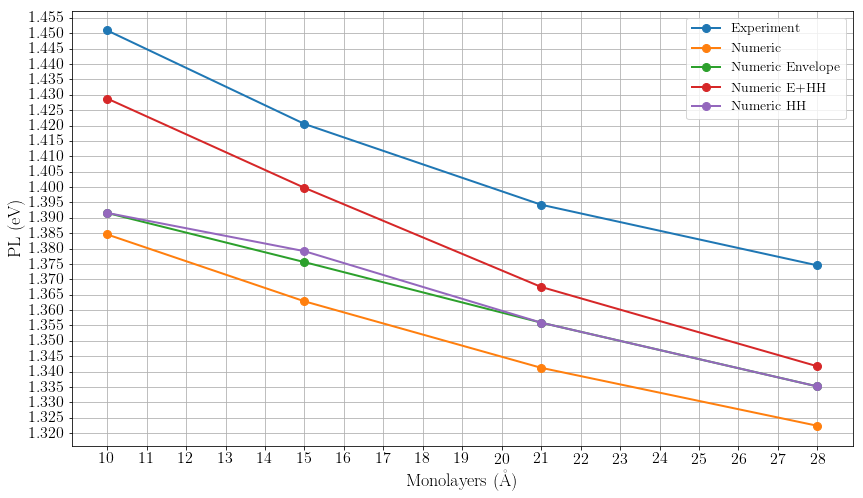

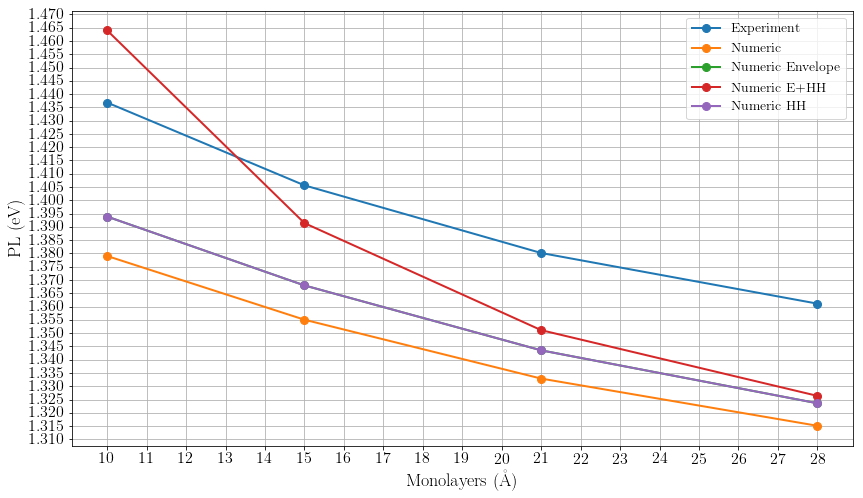

In [9]:
for T in tT:
    fig = plt.figure()
    ax  = fig.gca()

    ax.set_xticks(np.arange(0, 30, 1))
    ax.set_yticks(np.arange(0,  1.6, 0.005))
    ax.set_xlabel('Monolayers (\AA)')
    ax.set_ylabel('PL (eV)')

    ax.plot(ml_grid, PL_experiment[T], '-o', label='Experiment')
    ax.plot(ml_grid, PL_numeric[T]   , '-o', label='Numeric')
    ax.plot(ml_grid, PLR_envelope[T] , '-o', label='Numeric Envelope')
    ax.plot(ml_grid, PLR_e_hh[T]     , '-o', label='Numeric E+HH')
    ax.plot(ml_grid, PLR_hh[T]       , '-o', label='Numeric HH')

    plt.legend()
    plt.grid(True)
    plt.plot()

In [ ]:
[1.45091, 1.42051, 1.39425, 1.37454]

In [ ]:
#massa max

GAP x: 0.00, ML=28, T=525 C, R=0.867, PL=1.32239691 eV, PL_env=1.33518255 eV, PL_e_hh=1.34173195 eV, PL_hh=1.33518255 eV, 
GAP x: 0.11, ML=28, T=525 C, R=0.867, PL=1.33328580 eV, PL_env=1.34607144 eV, PL_e_hh=1.35262084 eV, PL_hh=1.34607144 eV, 
GAP x: 0.22, ML=28, T=525 C, R=0.867, PL=1.34417468 eV, PL_env=1.35696033 eV, PL_e_hh=1.36350973 eV, PL_hh=1.35696033 eV, 
GAP x: 0.33, ML=28, T=525 C, R=0.867, PL=1.35506357 eV, PL_env=1.36784922 eV, PL_e_hh=1.37439862 eV, PL_hh=1.36784922 eV, 
GAP x: 0.44, ML=28, T=525 C, R=0.867, PL=1.36595246 eV, PL_env=1.37873811 eV, PL_e_hh=1.38528750 eV, PL_hh=1.37873811 eV, 
GAP x: 0.56, ML=28, T=525 C, R=0.867, PL=1.37684135 eV, PL_env=1.38962700 eV, PL_e_hh=1.39617639 eV, PL_hh=1.38962700 eV, 
GAP x: 0.67, ML=28, T=525 C, R=0.867, PL=1.38773024 eV, PL_env=1.40051589 eV, PL_e_hh=1.40706528 eV, PL_hh=1.40051589 eV, 
GAP x: 0.78, ML=28, T=525 C, R=0.867, PL=1.39861913 eV, PL_env=1.41140477 eV, PL_e_hh=1.41795417 eV, PL_hh=1.41140477 eV, 
GAP x: 0.89, ML=28, T=525 C, R=0.867, PL=1.40950802 eV, PL_env=1.42229366 eV, PL_e_hh=1.42884306 eV, PL_hh=1.42229366 eV, 
GAP x: 1.00, ML=28, T=525 C, R=0.867, PL=1.42039691 eV, PL_env=1.43318255 eV, PL_e_hh=1.43973195 eV, PL_hh=1.43318255 eV, 
    
#massa min

GAP x: 0.00, ML=28, T=525 C, R=0.867, PL=1.32419230 eV, PL_env=1.33697795 eV, PL_e_hh=1.34352734 eV, PL_hh=1.33697795 eV, 
GAP x: 0.11, ML=28, T=525 C, R=0.867, PL=1.33508119 eV, PL_env=1.34786684 eV, PL_e_hh=1.35441623 eV, PL_hh=1.34786684 eV, 
GAP x: 0.22, ML=28, T=525 C, R=0.867, PL=1.34597008 eV, PL_env=1.35875573 eV, PL_e_hh=1.36530512 eV, PL_hh=1.35875573 eV, 
GAP x: 0.33, ML=28, T=525 C, R=0.867, PL=1.35685897 eV, PL_env=1.36964461 eV, PL_e_hh=1.37619401 eV, PL_hh=1.36964461 eV, 
GAP x: 0.44, ML=28, T=525 C, R=0.867, PL=1.36774786 eV, PL_env=1.38053350 eV, PL_e_hh=1.38708290 eV, PL_hh=1.38053350 eV, 
GAP x: 0.56, ML=28, T=525 C, R=0.867, PL=1.37863675 eV, PL_env=1.39142239 eV, PL_e_hh=1.39797179 eV, PL_hh=1.39142239 eV, 
GAP x: 0.67, ML=28, T=525 C, R=0.867, PL=1.38952564 eV, PL_env=1.40231128 eV, PL_e_hh=1.40886068 eV, PL_hh=1.40231128 eV, 
GAP x: 0.78, ML=28, T=525 C, R=0.867, PL=1.40041452 eV, PL_env=1.41320017 eV, PL_e_hh=1.41974957 eV, PL_hh=1.41320017 eV, 
GAP x: 0.89, ML=28, T=525 C, R=0.867, PL=1.41130341 eV, PL_env=1.42408906 eV, PL_e_hh=1.43063846 eV, PL_hh=1.42408906 eV, 
GAP x: 1.00, ML=28, T=525 C, R=0.867, PL=1.42219230 eV, PL_env=1.43497795 eV, PL_e_hh=1.44152734 eV, PL_hh=1.43497795 eV, 

In [ ]:
#massa max

GAP x: 0.00, ML=10, T=525 C, R=0.867, PL=1.38459237 eV, PL_env=1.39159237 eV, PL_e_hh=1.42876609 eV, PL_hh=1.39159237 eV, 
GAP x: 0.11, ML=10, T=525 C, R=0.867, PL=1.39548126 eV, PL_env=1.40248126 eV, PL_e_hh=1.43965498 eV, PL_hh=1.40248126 eV, 
GAP x: 0.22, ML=10, T=525 C, R=0.867, PL=1.40637015 eV, PL_env=1.41337015 eV, PL_e_hh=1.45054387 eV, PL_hh=1.41337015 eV, 
GAP x: 0.33, ML=10, T=525 C, R=0.867, PL=1.41725904 eV, PL_env=1.42425904 eV, PL_e_hh=1.46143276 eV, PL_hh=1.42425904 eV, 
GAP x: 0.44, ML=10, T=525 C, R=0.867, PL=1.42814793 eV, PL_env=1.43514793 eV, PL_e_hh=1.47232164 eV, PL_hh=1.43514793 eV, 
GAP x: 0.56, ML=10, T=525 C, R=0.867, PL=1.43903682 eV, PL_env=1.44603682 eV, PL_e_hh=1.48321053 eV, PL_hh=1.44603682 eV, 
GAP x: 0.67, ML=10, T=525 C, R=0.867, PL=1.44992571 eV, PL_env=1.45692571 eV, PL_e_hh=1.49409942 eV, PL_hh=1.45692571 eV, 
GAP x: 0.78, ML=10, T=525 C, R=0.867, PL=1.46081460 eV, PL_env=1.46781460 eV, PL_e_hh=1.50498831 eV, PL_hh=1.46781460 eV, 
GAP x: 0.89, ML=10, T=525 C, R=0.867, PL=1.47170349 eV, PL_env=1.47870349 eV, PL_e_hh=1.51587720 eV, PL_hh=1.47870349 eV, 
GAP x: 1.00, ML=10, T=525 C, R=0.867, PL=1.48259237 eV, PL_env=1.48959237 eV, PL_e_hh=1.52676609 eV, PL_hh=1.48959237 eV, 

#massa min

GAP x: 0.00, ML=10, T=525 C, R=0.867, PL=1.38552621 eV, PL_env=1.39252621 eV, PL_e_hh=1.44092266 eV, PL_hh=1.39252621 eV, 
GAP x: 0.11, ML=10, T=525 C, R=0.867, PL=1.39641510 eV, PL_env=1.40341510 eV, PL_e_hh=1.45181155 eV, PL_hh=1.40341510 eV, 
GAP x: 0.22, ML=10, T=525 C, R=0.867, PL=1.40730399 eV, PL_env=1.41430399 eV, PL_e_hh=1.46270044 eV, PL_hh=1.41430399 eV, 
GAP x: 0.33, ML=10, T=525 C, R=0.867, PL=1.41819288 eV, PL_env=1.42519288 eV, PL_e_hh=1.47358933 eV, PL_hh=1.42519288 eV, 
GAP x: 0.44, ML=10, T=525 C, R=0.867, PL=1.42908177 eV, PL_env=1.43608177 eV, PL_e_hh=1.48447822 eV, PL_hh=1.43608177 eV, 
GAP x: 0.56, ML=10, T=525 C, R=0.867, PL=1.43997065 eV, PL_env=1.44697065 eV, PL_e_hh=1.49536711 eV, PL_hh=1.44697065 eV, 
GAP x: 0.67, ML=10, T=525 C, R=0.867, PL=1.45085954 eV, PL_env=1.45785954 eV, PL_e_hh=1.50625600 eV, PL_hh=1.45785954 eV, 
GAP x: 0.78, ML=10, T=525 C, R=0.867, PL=1.46174843 eV, PL_env=1.46874843 eV, PL_e_hh=1.51714489 eV, PL_hh=1.46874843 eV, 
GAP x: 0.89, ML=10, T=525 C, R=0.867, PL=1.47263732 eV, PL_env=1.47963732 eV, PL_e_hh=1.52803378 eV, PL_hh=1.47963732 eV, 
GAP x: 1.00, ML=10, T=525 C, R=0.867, PL=1.48352621 eV, PL_env=1.49052621 eV, PL_e_hh=1.53892266 eV, PL_hh=1.49052621 eV, 